# Exploratory notebook 
The goal of this notebook is to conduct the research part of "predicting the results of a match". Importing data from past seasons, transforming that data to extract new indicators (prétraitement et EDA), developping and evaluating models.

## Load packages and transform data

In [1]:

import pandas as pd             # manipulation de données tabulaires
import sys
import os
import json                     # pour afficher proprement le JSON si besoin
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath(".."))


In [2]:
from src.etl import fetch_matches, save_raw_matches, load_raw_matches

In [3]:
#matches_json=fetch_matches(2015,2024) #Ligue 1 saison 2024-2025

#save_raw_matches(matches_json,"../data/raw/")

matches_json=load_raw_matches("../data/raw/",season_id=2024)

In [4]:
matches_list = matches_json["matches"]
df_matches = pd.json_normalize(matches_list)

In [5]:
df_matches.head()

id               utcDate    status  matchday           stage group  \
0  497958  2024-08-16T18:45:00Z  FINISHED         1  REGULAR_SEASON  None   
1  497951  2024-08-17T15:00:00Z  FINISHED         1  REGULAR_SEASON  None   
2  497956  2024-08-17T17:00:00Z  FINISHED         1  REGULAR_SEASON  None   
3  497955  2024-08-17T19:00:00Z  FINISHED         1  REGULAR_SEASON  None   
4  497957  2024-08-18T13:00:00Z  FINISHED         1  REGULAR_SEASON  None   

            lastUpdated                                           referees  \
0  2025-06-01T20:20:47Z  [{'id': 57042, 'name': 'Willy Delajod', 'type'...   
1  2025-06-01T20:20:47Z  [{'id': 43926, 'name': 'Benoît Bastien', 'type...   
2  2025-06-01T20:20:47Z  [{'id': 57092, 'name': 'Eric Wattellier', 'typ...   
3  2025-06-01T20:20:47Z  [{'id': 9374, 'name': 'Clément Turpin', 'type'...   
4  2025-06-01T20:20:47Z  [{'id': 57087, 'name': 'Romain Lissorgue', 'ty...   

   area.id area.name  ... awayTeam.shortName awayTeam.tla  \
0     2081    France  ...                PSG          PSG   
1     2081    France  ...          Marseille          MAR   
2     2081    France  ...              Lille          LIL   
3     2081    France  ...      Saint-Étienne          ASS   
4     2081    France  ...               Nice          NIC   

                             awayTeam.crest score.winner score.duration  \
0  https://crests.football-data.org/524.png    AWAY_TEAM        REGULAR   
1  https://crests.football-data.org/516.png    AWAY_TEAM        REGULAR   
2  https://crests.football-data.org/521.png    AWAY_TEAM        REGULAR   
3  https://crests.football-data.org/527.png    HOME_TEAM        REGULAR   
4  https://crests.football-data.org/522.png    HOME_TEAM        REGULAR   

  score.fullTime.home score.fullTime.away  score.halfTime.home  \
0                   1                   4                    0   
1                   1                   5                    1   
2                   0                   2                    0   
3                   1                   0                    1   
4                   2                   1                    1   

  score.halfTime.away                                           odds.msg  
0                   1  Activate Odds-Package in User-Panel to retriev...  
1                   3  Activate Odds-Package in User-Panel to retriev...  
2                   1  Activate Odds-Package in User-Panel to retriev...  
3                   0  Activate Odds-Package in User-Panel to retriev...  
4                   1  Activate Odds-Package in User-Panel to retriev...  

[5 rows x 39 columns]

In [6]:
df_matches.columns


Index(['id', 'utcDate', 'status', 'matchday', 'stage', 'group', 'lastUpdated',
       'referees', 'area.id', 'area.name', 'area.code', 'area.flag',
       'competition.id', 'competition.name', 'competition.code',
       'competition.type', 'competition.emblem', 'season.id',
       'season.startDate', 'season.endDate', 'season.currentMatchday',
       'season.winner', 'homeTeam.id', 'homeTeam.name', 'homeTeam.shortName',
       'homeTeam.tla', 'homeTeam.crest', 'awayTeam.id', 'awayTeam.name',
       'awayTeam.shortName', 'awayTeam.tla', 'awayTeam.crest', 'score.winner',
       'score.duration', 'score.fullTime.home', 'score.fullTime.away',
       'score.halfTime.home', 'score.halfTime.away', 'odds.msg'],
      dtype='object')

## Transform data

There are a lot of columns that we ca let go of: date, stage, group, lastUpdated, referees, all the things explaining what competition it is, quite a lot of the variables explaining the teams (crest, shortname, tla as they are redundant.)

In [7]:
df_smaller=df_matches[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]]

In [8]:
df_smaller.head()

status  matchday  homeTeam.id      homeTeam.name  awayTeam.id  \
0  FINISHED         1          533        Le Havre AC          524   
1  FINISHED         1          512  Stade Brestois 29          516   
2  FINISHED         1          547     Stade de Reims          521   
3  FINISHED         1          548       AS Monaco FC          527   
4  FINISHED         1          519         AJ Auxerre          522   

            awayTeam.name score.winner  score.fullTime.home  \
0  Paris Saint-Germain FC    AWAY_TEAM                    1   
1  Olympique de Marseille    AWAY_TEAM                    1   
2               Lille OSC    AWAY_TEAM                    0   
3        AS Saint-Étienne    HOME_TEAM                    1   
4                OGC Nice    HOME_TEAM                    2   

   score.fullTime.away  
0                    4  
1                    5  
2                    2  
3                    0  
4                    1

This seems like a good base to make our predictions, and like we could construct some new variables from this. The variable e will want to predict is score.winner. The problem is we can't predict score winner knowing the number of goals scored... Of course. But we could create variables like "average number of goal scored per match earlier  in the season" and same for goals conceded. Similarly we could create variables such as "home team number of wins/loss at home" and "away team number of win/loss away" and such. I want to note that the variables related to the number of goals will need to be discarded for the "predicting the end of a season" project because we will predict HOME/DRAW/AWAY but not the exact score.

In [9]:
def prepa_donnee(df):
    df = df.sort_values(["matchday", "homeTeam.id"])

    df_home = df[["matchday", "homeTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "homeTeam.id": "team_id",
            "score.fullTime.home": "goals_for",
            "score.fullTime.away": "goals_against"
        }
    )
    df_home["is_home"] = True

    df_away = df[["matchday", "awayTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "awayTeam.id": "team_id",
            "score.fullTime.home": "goals_against",
            "score.fullTime.away": "goals_for"
        }
    )
    df_away["is_home"] = False

    df_home["win"]  = df_home["score.winner"] == "HOME_TEAM"
    df_home["loss"] = df_home["score.winner"] == "AWAY_TEAM"

    df_away["win"]  = df_away["score.winner"] == "AWAY_TEAM"
    df_away["loss"] = df_away["score.winner"] == "HOME_TEAM"

    df_long = pd.concat([df_home, df_away], ignore_index=True)
    df_long = df_long.sort_values(["team_id", "matchday"])

    df_long["points"] = df_long.apply(pts, axis=1)
    df_long["points_before_match"] = (
        df_long.groupby("team_id")["points"]
            .cumsum()
            .shift(1)
    )
    df_long["avg_points_before_match"] = (
        df_long["points_before_match"]/(df_long["matchday"]-1)
    )

    df_long["goal_diff"] = df_long["goals_for"] - df_long["goals_against"]


    df_long["avg_goals_for"] = df_long.groupby("team_id")["goals_for"] \
                                    .transform(lambda s: s.shift(1).expanding().mean())

    df_long["avg_goals_against"] = df_long.groupby("team_id")["goals_against"] \
                                        .transform(lambda s: s.shift(1).expanding().mean())

    df_long["cum_goals_for"] = (
        df_long.groupby("team_id")["goals_for"].cumsum().shift(1)
    )
    df_long["cum_goals_against"] = (
        df_long.groupby("team_id")["goals_against"].cumsum().shift(1)
    )
    df_long["cum_goal_diff"] = df_long["cum_goals_for"] - df_long["cum_goals_against"]


    df_long["home_win_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_win_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_loss_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["home_loss_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long = df_long.sort_values(
        ["matchday", "points_before_match", "cum_goal_diff", "cum_goals_for"],
        ascending=[True, False, False, False]
    )

    # On calcule le ranking par matchday en utilisant cumcount
    df_long["ranking_before_match"] = (
        df_long.groupby("matchday").cumcount() + 1
    )



    df_long["form_last5"] = (
        df_long.groupby("team_id")["points"]
            .transform(lambda s: s.shift(1).rolling(5, min_periods=1).sum())
    )

    df_stats=df_long[["team_id", "matchday","avg_points_before_match", "cum_goal_diff", "cum_goals_for", "cum_goals_against",
    "avg_goals_for", "avg_goals_against",
    "home_win_rate", "away_win_rate", "home_loss_rate", "away_loss_rate",
    "ranking_before_match", "form_last5"]]


    df_merged = df\
    .merge(
        df_stats.add_prefix("home_"),
        left_on=["homeTeam.id", "matchday"],
        right_on=["home_team_id", "home_matchday"],
        how="left"
    )\
    .merge(
        df_stats.add_prefix("away_"),
        left_on=["awayTeam.id", "matchday"],
        right_on=["away_team_id", "away_matchday"],
        how="left"
    )
    df_merged.drop(columns=["status","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
        "home_team_id", "home_matchday", 
        "away_team_id", "away_matchday","score.fullTime.home","score.fullTime.away",
        "home_away_win_rate","home_away_loss_rate","away_home_win_rate","away_home_loss_rate",
        "home_cum_goal_diff","away_cum_goal_diff","home_cum_goals_for","away_cum_goals_for",
        "home_cum_goals_against","away_cum_goals_against"
    ],inplace=True)

    df_for_model=df_merged[df_merged["matchday"]>5]

    return df_for_model

In [10]:
from src.etl import pts

In [11]:
df_for_training=prepa_donnee(df_smaller)

In [12]:
df_for_training.head()

matchday score.winner  home_avg_points_before_match  home_avg_goals_for  \
45         6    AWAY_TEAM                           1.0                 0.8   
46         6    HOME_TEAM                           0.6                 1.0   
47         6    HOME_TEAM                           2.6                 3.4   
48         6    AWAY_TEAM                           0.4                 0.6   
49         6    AWAY_TEAM                           1.2                 1.4   

    home_avg_goals_against  home_home_win_rate  home_home_loss_rate  \
45                     1.2            0.333333             0.333333   
46                     2.4            0.500000             0.500000   
47                     0.8            1.000000             0.000000   
48                     1.8            0.000000             0.666667   
49                     2.0            0.500000             0.500000   

    home_ranking_before_match  home_form_last5  away_avg_points_before_match  \
45                         13              5.0                           0.8   
46                         16              3.0                           1.2   
47                          1             13.0                           1.4   
48                         18              2.0                           1.6   
49                         12              6.0                           1.4   

    away_avg_goals_for  away_avg_goals_against  away_away_win_rate  \
45                 1.2                     2.2                 0.0   
46                 1.6                     2.0                 0.0   
47                 1.8                     1.2                 0.0   
48                 1.4                     1.4                 0.5   
49                 1.6                     1.4                 0.5   

    away_away_loss_rate  away_ranking_before_match  away_form_last5  
45                  0.5                         14              4.0  
46                  1.0                         11              6.0  
47                  1.0                          8              7.0  
48                  0.0                          6              8.0  
49                  0.5                          9              7.0

In [13]:
df_for_training.columns

Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')

## Analyse exploratoire

### 1 Comprendre la cible

Est ce que les classes sont équilibrées? 

In [14]:
df_for_training['score.winner'].value_counts(normalize=True)


score.winner
HOME_TEAM    0.467433
AWAY_TEAM    0.337165
DRAW         0.195402
Name: proportion, dtype: float64

## 2 Distribution des variables

In [15]:
import matplotlib.pyplot as plt

In [16]:
variable=['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5']


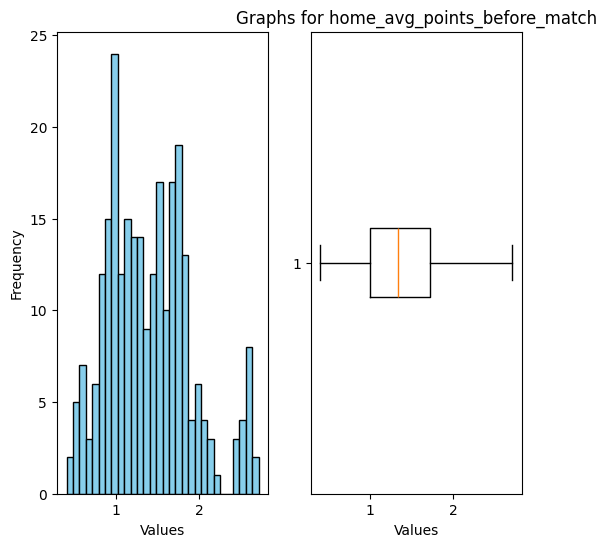

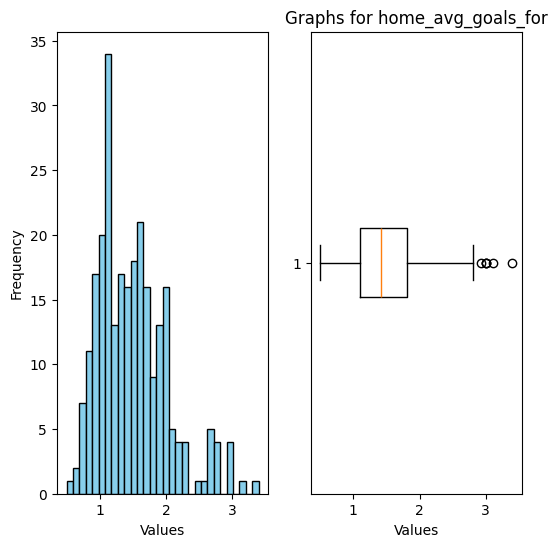

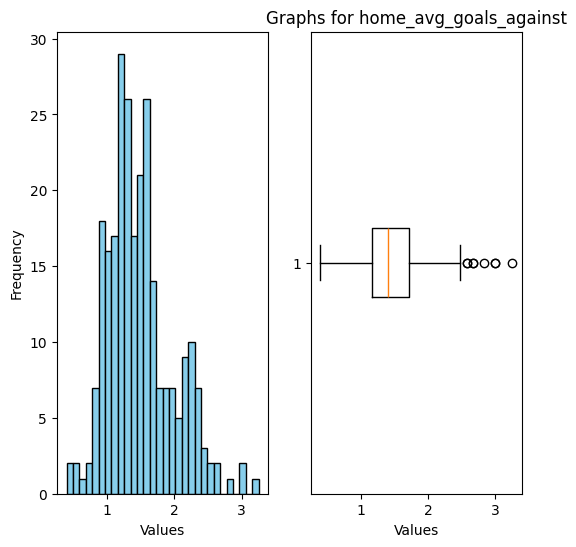

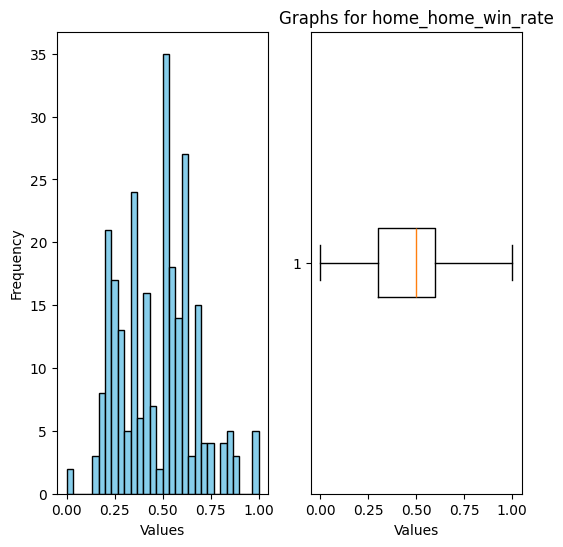

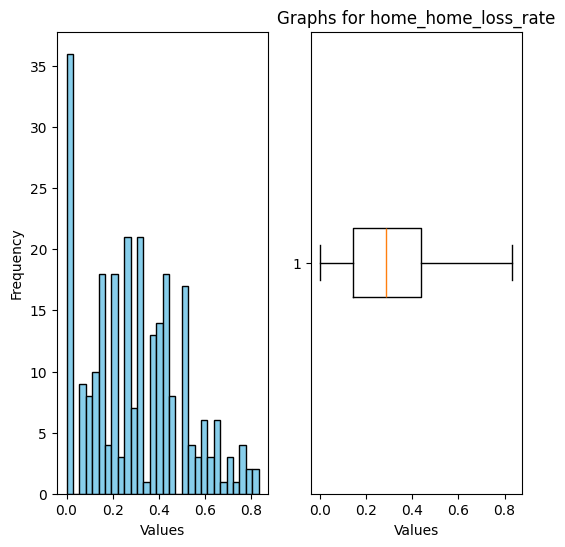

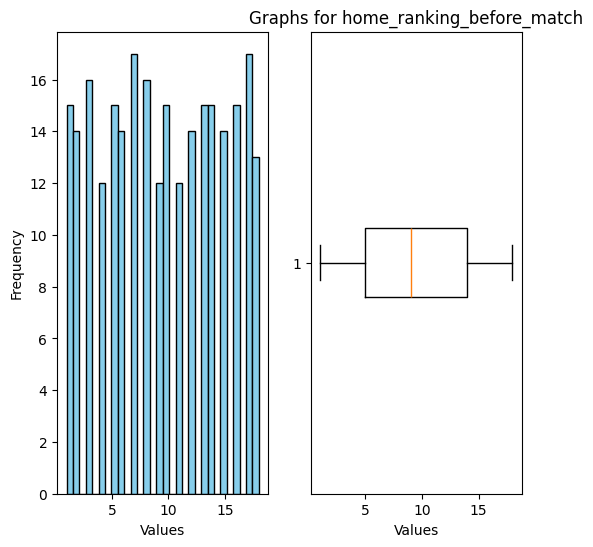

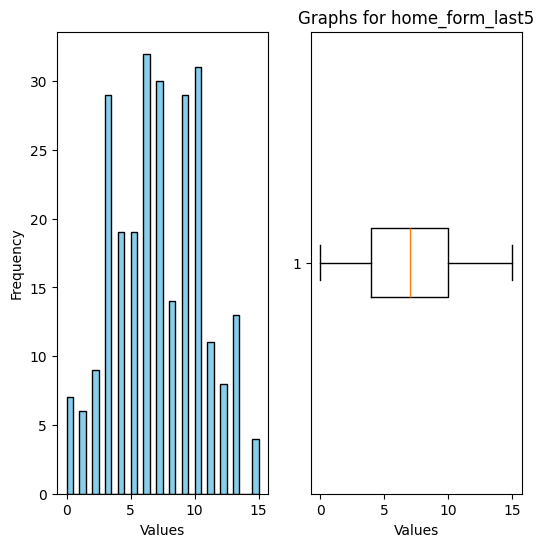

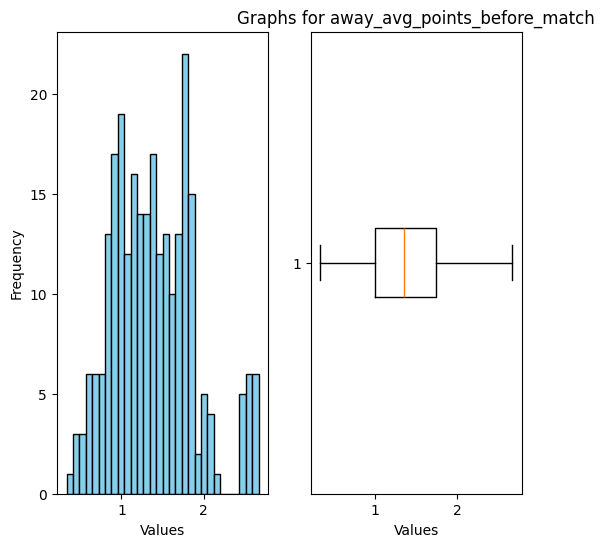

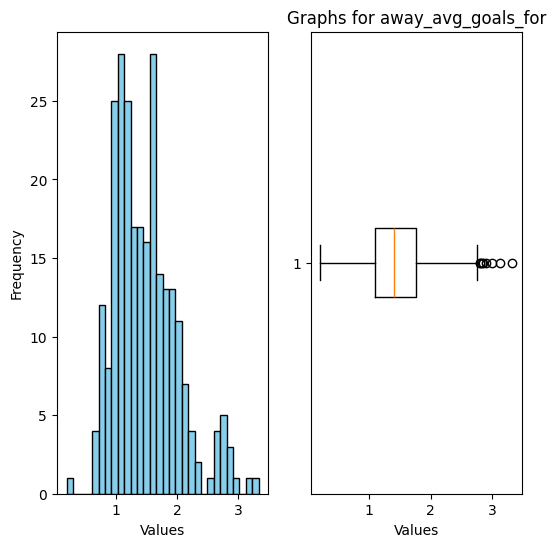

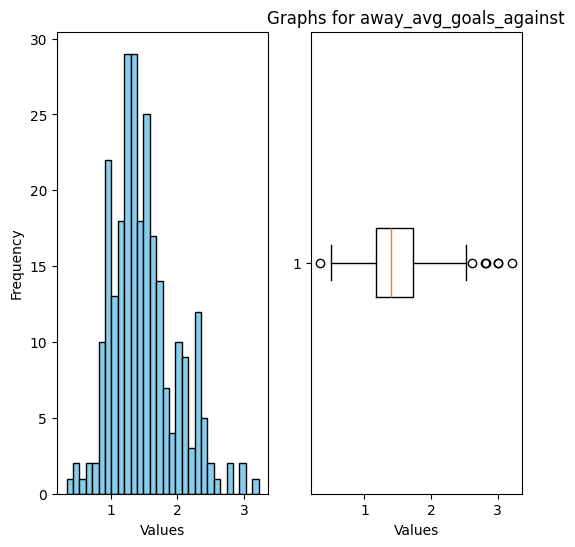

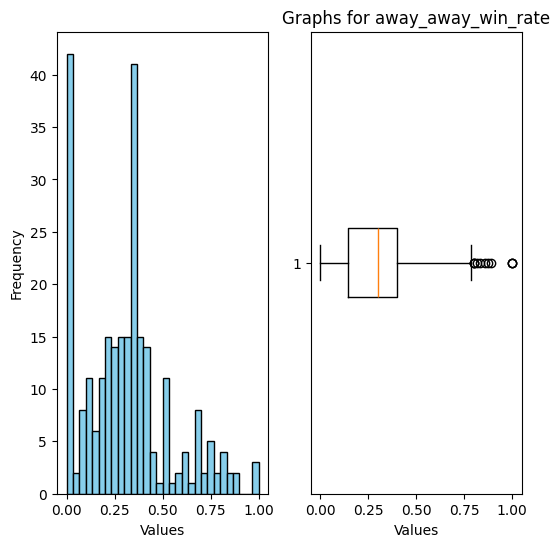

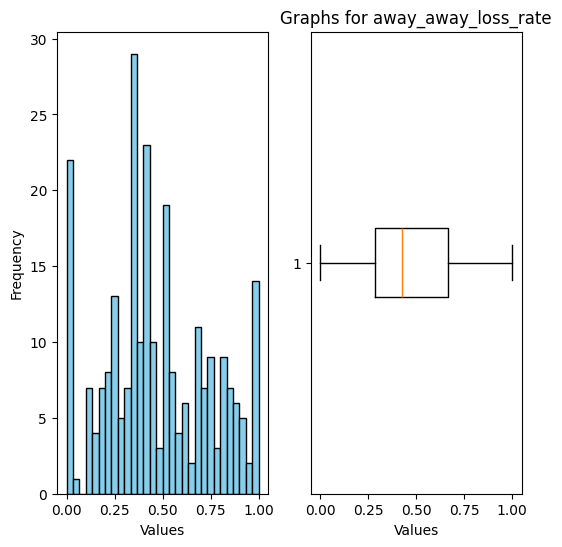

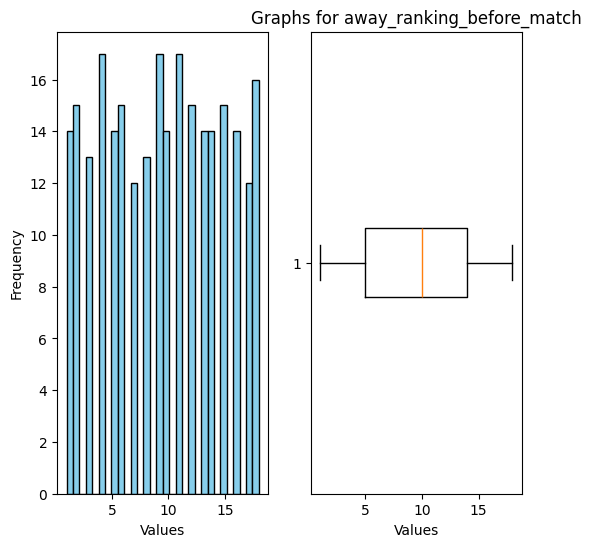

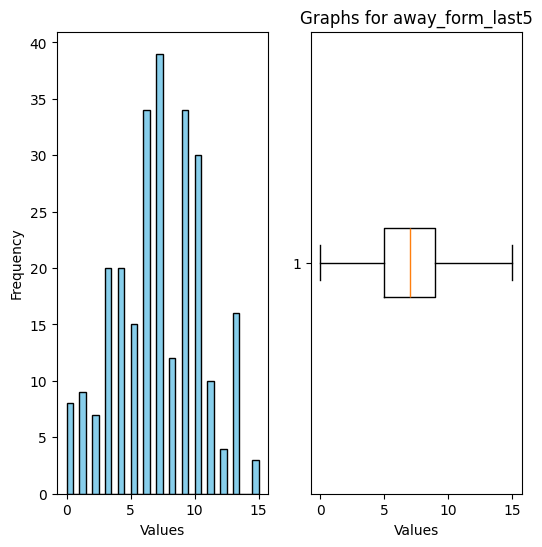

In [17]:
#variable=['home_avg_points_before_match', 'home_avg_goals_for']

for var in variable:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    axs[0].hist(df_for_training[var],bins=30, color='skyblue', edgecolor='black')
    # Adding labels and title
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    #axs[0].set_title(f'Basic Histogram of {var}')


    axs[1].boxplot(df_for_training[var],vert=False)
    axs[1].set_xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()


## 3 Analyse des corrélations

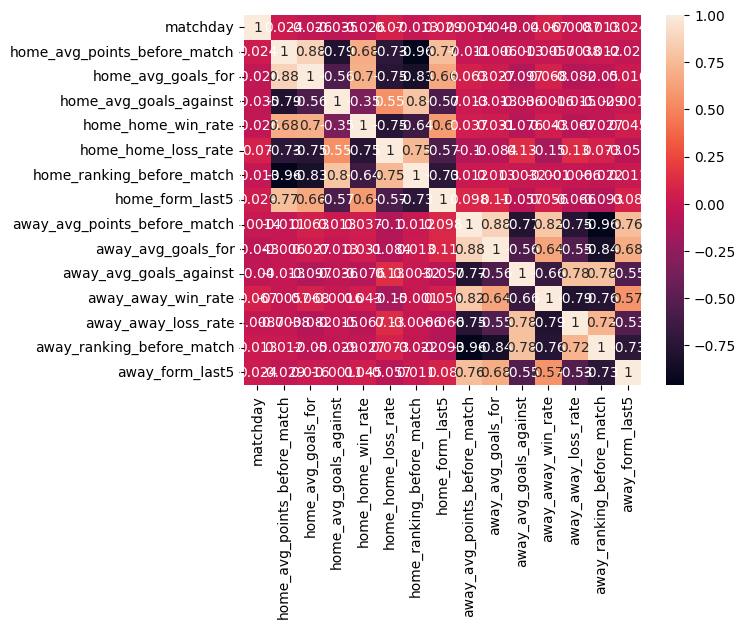

In [18]:
import seaborn as sns

corr=df_for_training.corr(numeric_only=True)

#plotting the heatmap for correlation
ax = sns.heatmap(corr, annot=True)


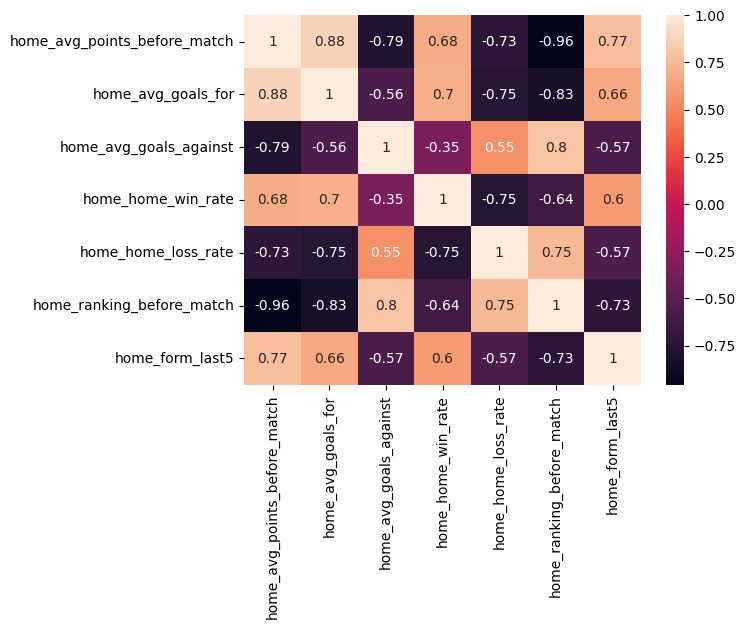

In [19]:
ax = sns.heatmap(corr.iloc[1:8,1:8], annot=True)


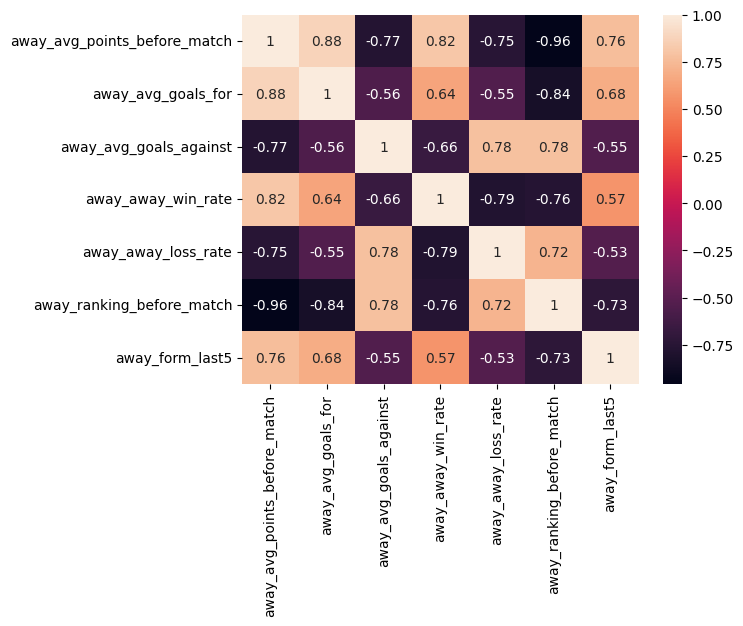

In [20]:

ax = sns.heatmap(corr.iloc[8:16,8:16], annot=True)


There are a few things of note: first, the average point of a team before the match and the ranking before the match are too closely related to both be included in the final model, one of them will need to be excluded. Since the ranking are in a larger scaler than the rest, and also since we might include both seasons with 18 and 20 teams, it seems that the rankings will be excluded.

## 4 Relation entre variable et cible

In [21]:
variable=['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_form_last5']


 Variable : home_avg_points_before_match
    → F = 10.7104
    → p-value = 0.000034


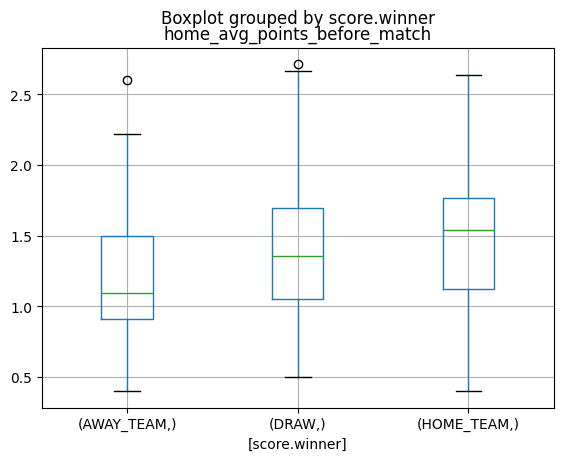


 Variable : home_avg_goals_for
    → F = 15.6176
    → p-value = 0.000000


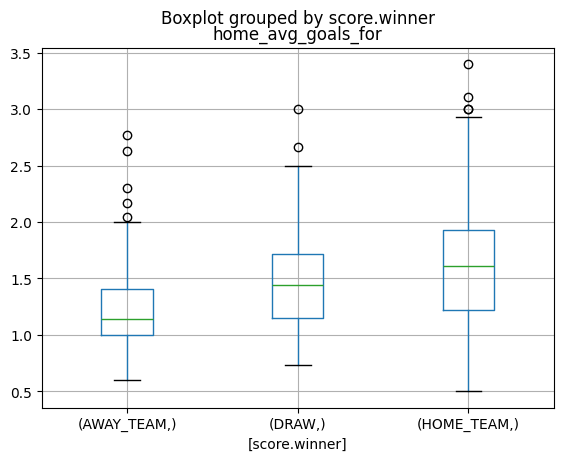


 Variable : home_avg_goals_against
    → F = 4.1835
    → p-value = 0.016292


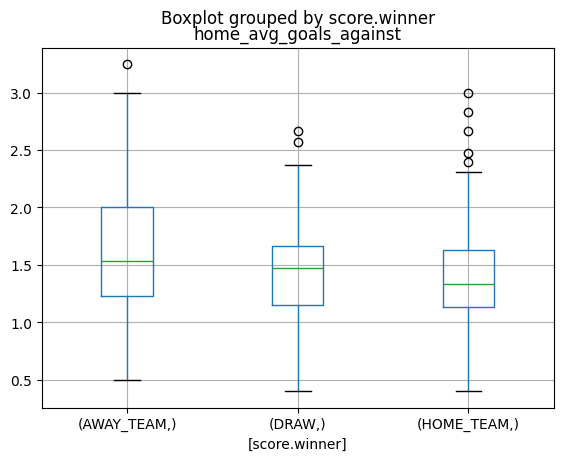


 Variable : home_home_win_rate
    → F = 11.2649
    → p-value = 0.000020


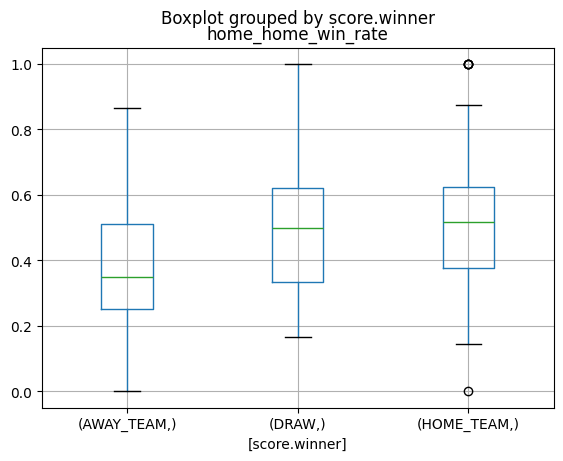


 Variable : home_home_loss_rate
    → F = 9.7140
    → p-value = 0.000086


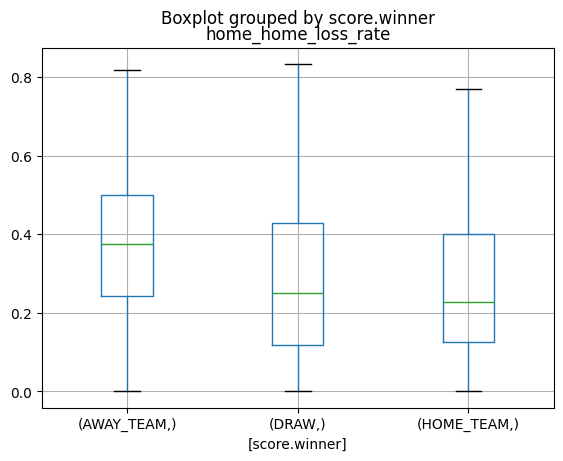


 Variable : home_form_last5
    → F = 3.4674
    → p-value = 0.032659


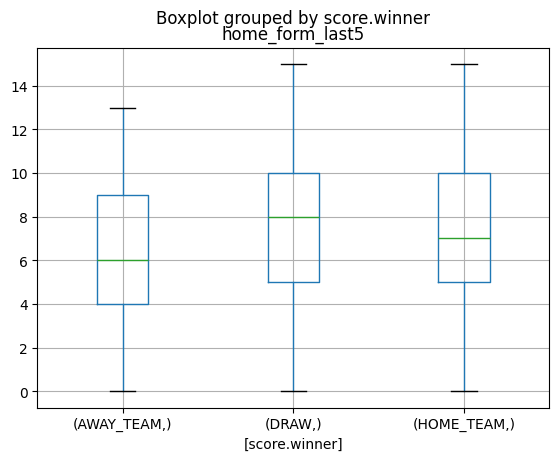


 Variable : away_avg_points_before_match
    → F = 5.3242
    → p-value = 0.005422


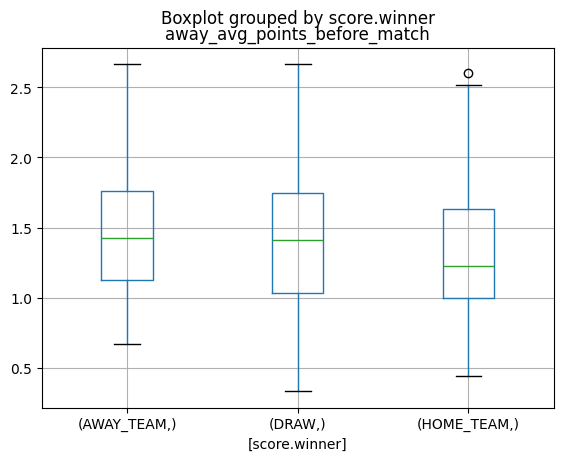


 Variable : away_avg_goals_for
    → F = 4.6790
    → p-value = 0.010090


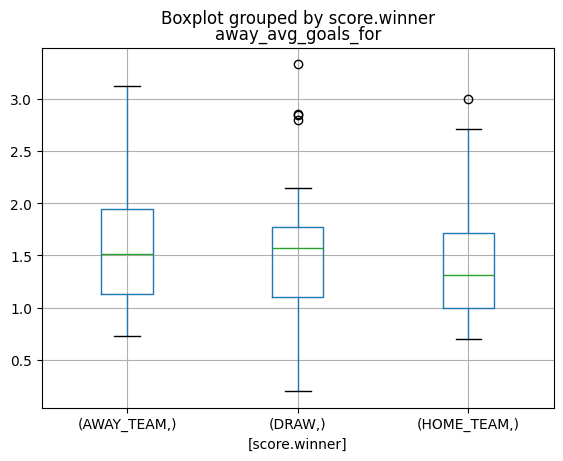


 Variable : away_avg_goals_against
    → F = 7.1206
    → p-value = 0.000977


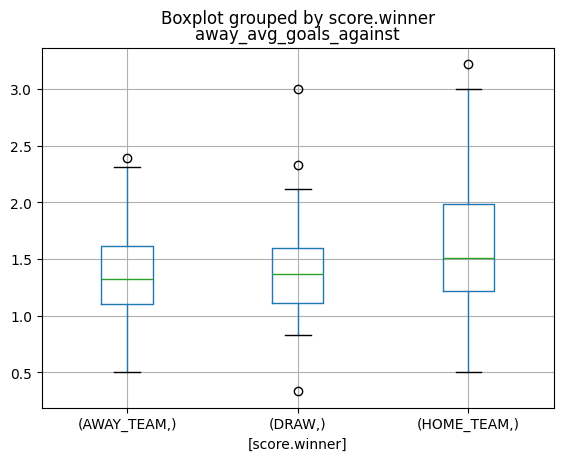


 Variable : away_away_win_rate
    → F = 4.1178
    → p-value = 0.017363


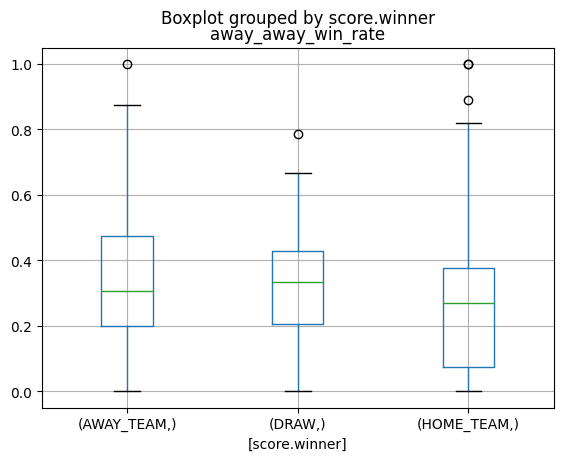


 Variable : away_away_loss_rate
    → F = 6.1740
    → p-value = 0.002403


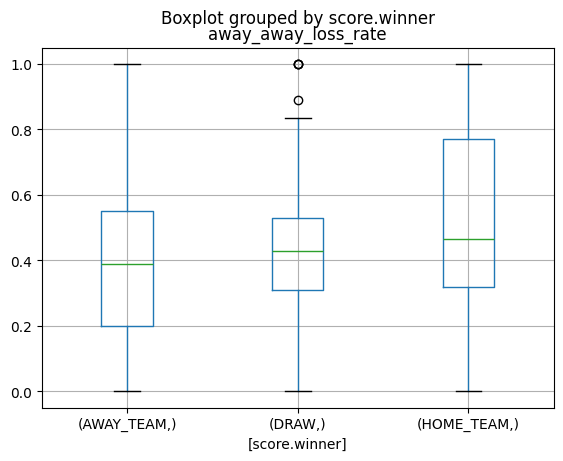


 Variable : away_form_last5
    → F = 2.7013
    → p-value = 0.069015


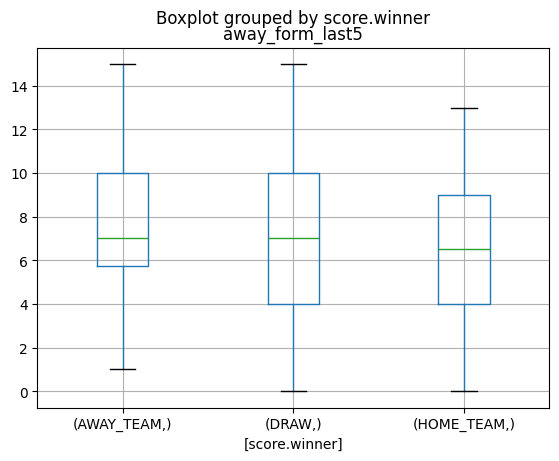

In [22]:
from scipy.stats import f_oneway

classes = ["HOME_TEAM", "AWAY_TEAM", "DRAW"]

for var in variable:
    groups = [df_for_training[df_for_training["score.winner"] == c][var].dropna()
              for c in classes]

    f_stat, p_val = f_oneway(*groups)

    print(f"\n Variable : {var}")
    print(f"    → F = {f_stat:.4f}")
    print(f"    → p-value = {p_val:.6f}")
    df_for_training.boxplot(column=[var],by=['score.winner'])
    #plt.xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    #plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()

All variables seems strongly related to the cible.

## 5 Analyse temporelle

Vérifier la stabilité des variables notamment en début de saison (on exclut les 5 premiers matchs mais est-ce suffisant)
On a déjà vu quand on a tracé les corrélations que le matchday était peu corrélé au reste, mais on souhaite le vérifier ici.

In [23]:
df_for_training.columns

Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')


 Variable : home_avg_points_before_match
    → Correlation with mathchday = 0.0245


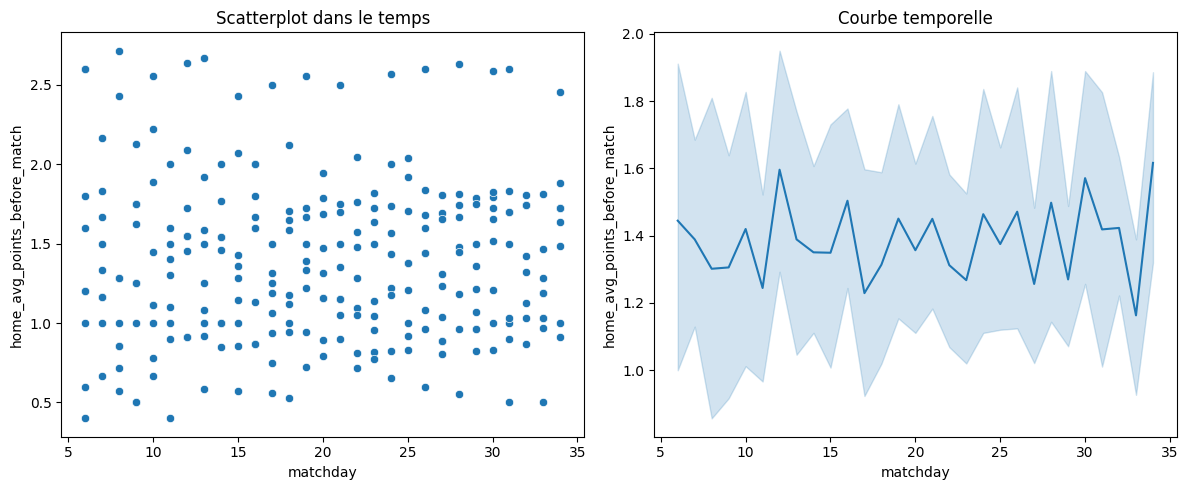


 Variable : home_avg_goals_for
    → Correlation with mathchday = -0.0261


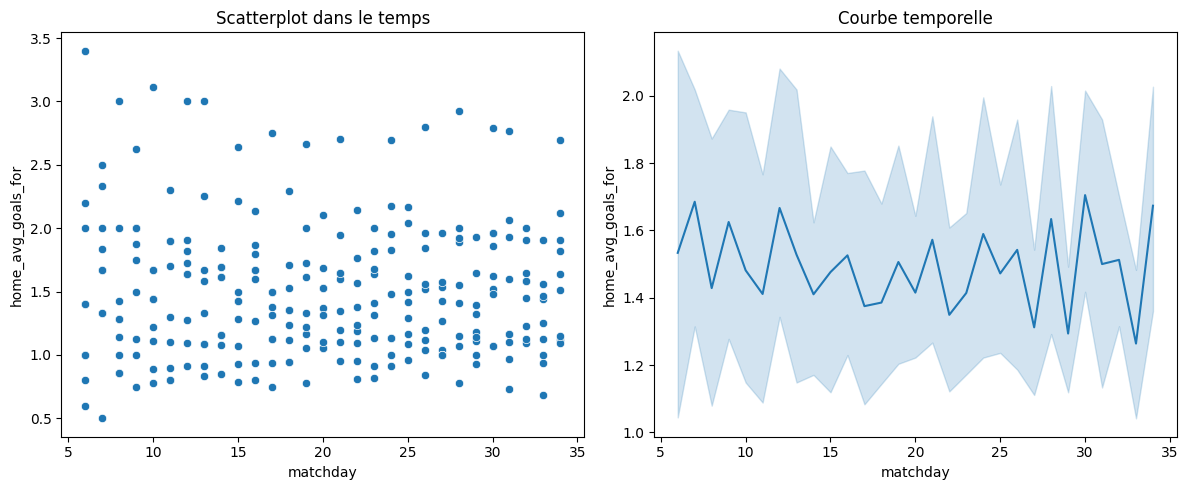


 Variable : home_avg_goals_against
    → Correlation with mathchday = -0.0351


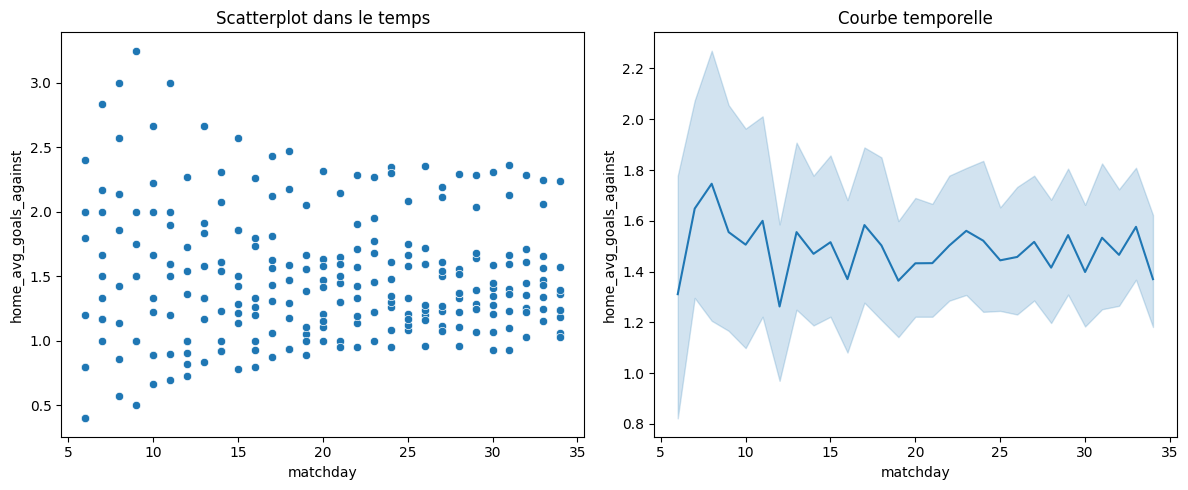


 Variable : home_home_win_rate
    → Correlation with mathchday = -0.0260


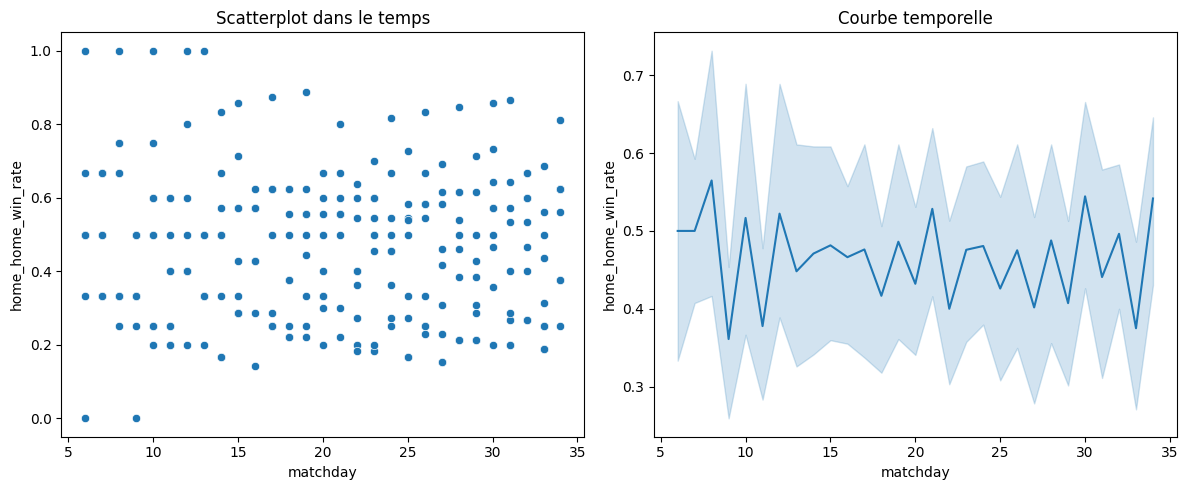


 Variable : home_home_loss_rate
    → Correlation with mathchday = 0.0696


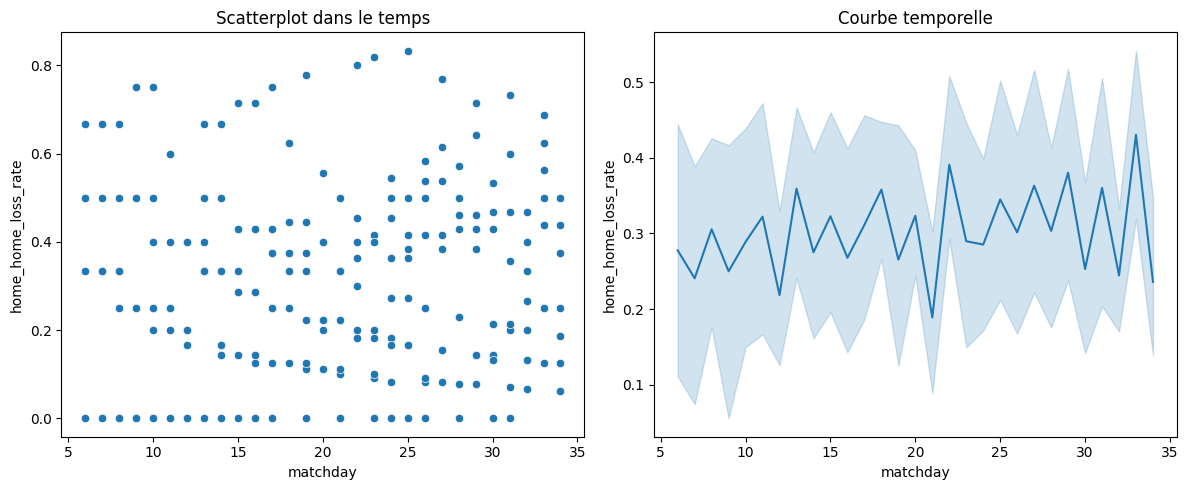


 Variable : home_form_last5
    → Correlation with mathchday = 0.0291


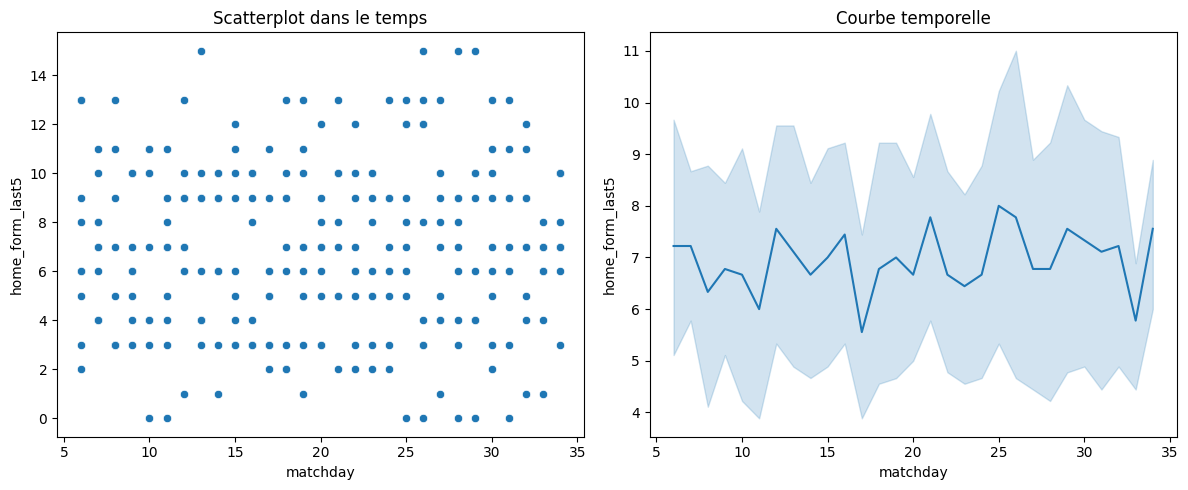


 Variable : away_avg_points_before_match
    → Correlation with mathchday = 0.0014


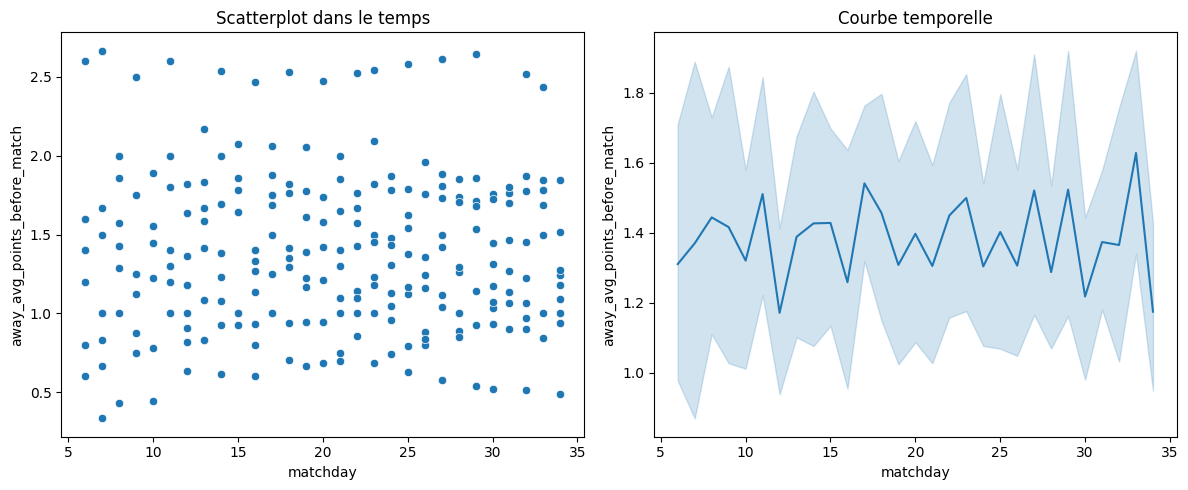


 Variable : away_avg_goals_for
    → Correlation with mathchday = -0.0431


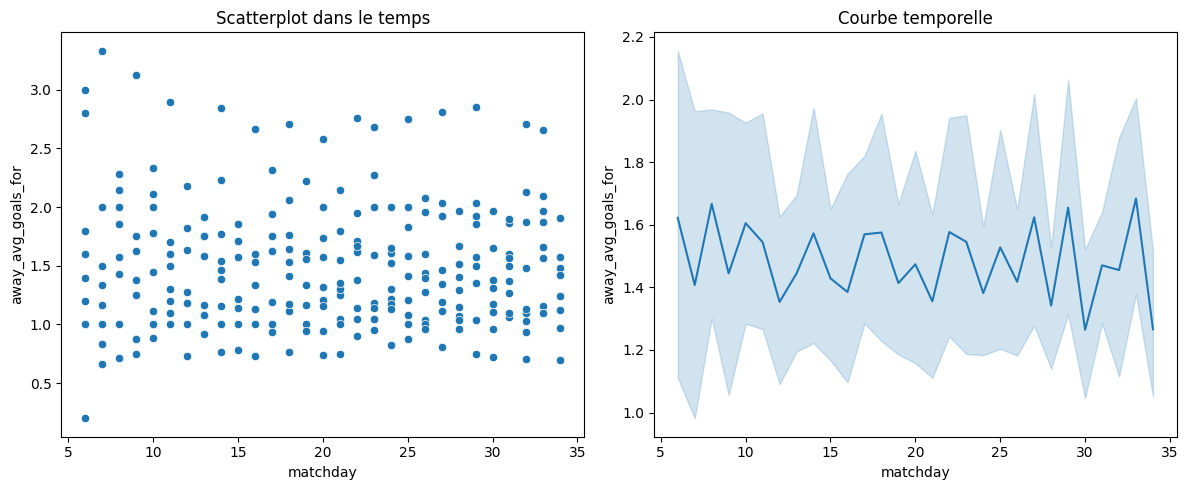


 Variable : away_avg_goals_against
    → Correlation with mathchday = -0.0400


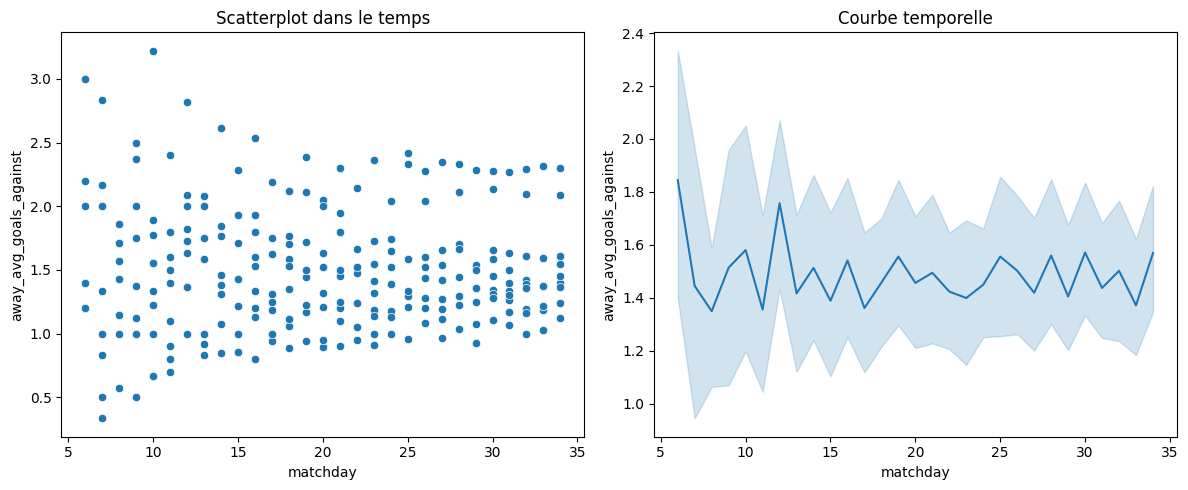


 Variable : away_away_win_rate
    → Correlation with mathchday = 0.0672


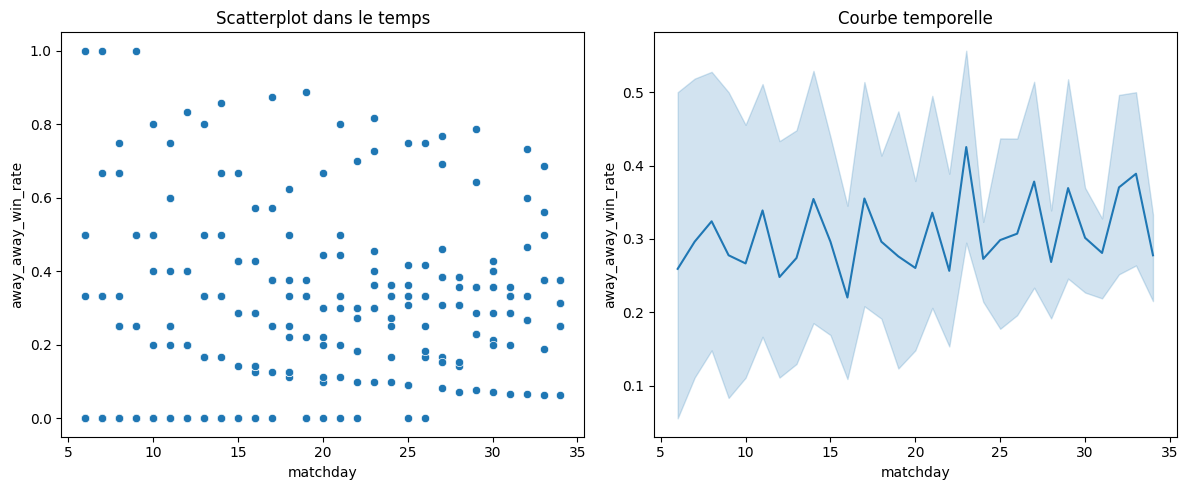


 Variable : away_away_loss_rate
    → Correlation with mathchday = -0.0087


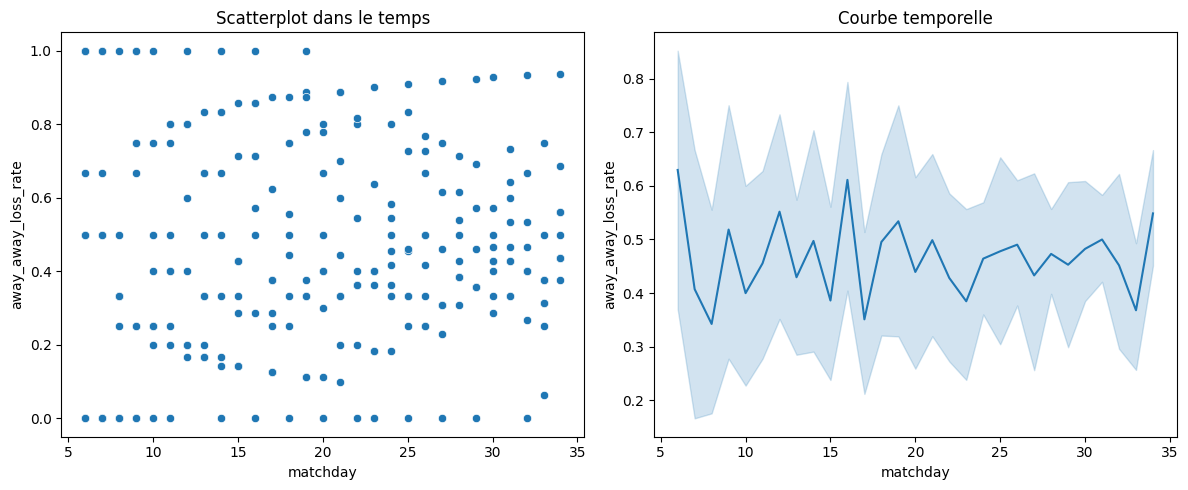


 Variable : away_form_last5
    → Correlation with mathchday = 0.0235


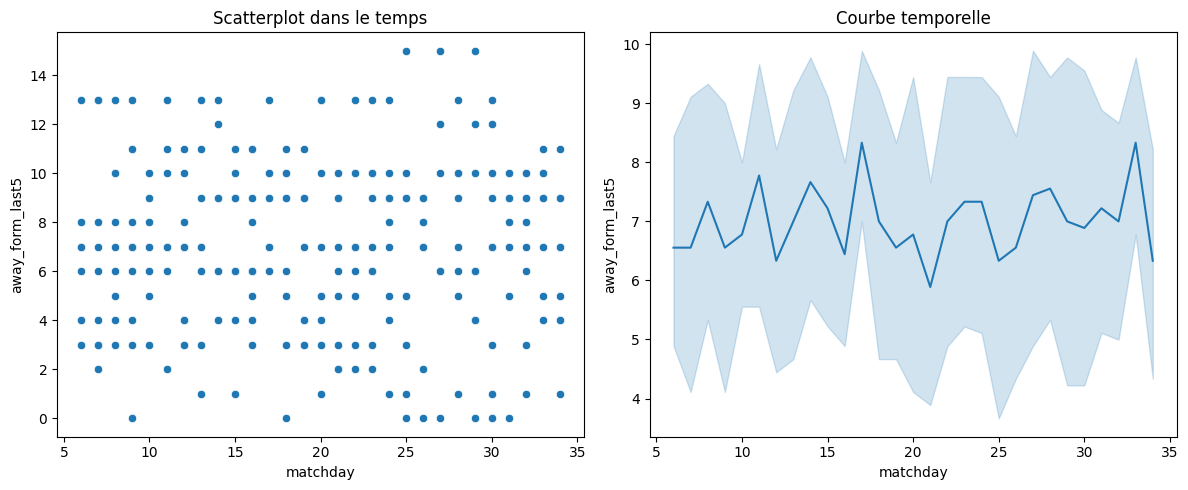

In [24]:
for var in variable:
    corr1=corr.loc["matchday",var]
    print(f"\n Variable : {var}")
    print(f"    → Correlation with mathchday = {corr1:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graph 1
    sns.scatterplot(
        data=df_for_training,
        x="matchday",
        y=var,
        ax=axs[0]
    )
    axs[0].set_title("Scatterplot dans le temps")

    # Graph 2
    sns.lineplot(
        data=df_for_training,
        x="matchday",
        y=var,
        ax=axs[1]
    )
    axs[1].set_title("Courbe temporelle")

    plt.tight_layout()
    plt.show()



# Preparation à la modélisation

objectif: finir de nettoyer data_for_training et séparer en X/Y, et préparer pour validation (valider sur la saison 2025-2026 en excluant les 5 premiers matchs comme sur la base d'entrainement)
-ajouter plus de saisons

In [72]:
matches_2023=load_raw_matches("../data/raw/",season_id=2023)
#matches_2023=fetch_matches(2015,season_id=2023)
#save_raw_matches(matches_2023,"../data/raw/")
df_matches_2023 = pd.json_normalize(matches_2023["matches"])
df_train_2023=prepa_donnee(df_matches_2023[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]])


In [73]:
print(df_for_training.shape)
print(df_train_2023.shape)

df_training = pd.concat([df_for_training, df_train_2023], ignore_index=True)
print(df_training.shape)


(261, 16)
(261, 16)
(522, 16)


X should not include the columns 'matchday', 'score.winner', 'home_ranking_before_match' and 'away_ranking_before_match' while Y should be score.winner.

In [74]:
X_train=df_training.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match"])
y_train=df_training["score.winner"]

In [75]:
y_train.value_counts()/y_train.shape[0]

score.winner
HOME_TEAM    0.434866
AWAY_TEAM    0.348659
DRAW         0.216475
Name: count, dtype: float64

Now we will get the validation dataset

In [76]:
matches_2025=load_raw_matches("../data/raw/",season_id=2025)
df_matches_2025 = pd.json_normalize(matches_2025["matches"])

df_for_validation=prepa_donnee(df_matches_2025[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]])

In [77]:
df_for_validation=df_for_validation[df_for_validation.matchday<=15]

In [78]:
X_valid=df_for_validation.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match"],inplace=False)
y_valid=df_for_validation["score.winner"]

## Pipelines

In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    log_loss, brier_score_loss, accuracy_score, confusion_matrix
)
from sklearn.calibration import calibration_curve

In [80]:
num_features = ['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_form_last5', 'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_form_last5']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)
    ]
)

# Modélisation

## Finir les pipelines

In [33]:
pipelines={
    'logreg': make_pipeline(preprocessor,LogisticRegression(max_iter=1000,solver='lbfgs')),
    'forest':make_pipeline(preprocessor,RandomForestClassifier()),
    'gboost':make_pipeline(preprocessor,GradientBoostingClassifier())
}

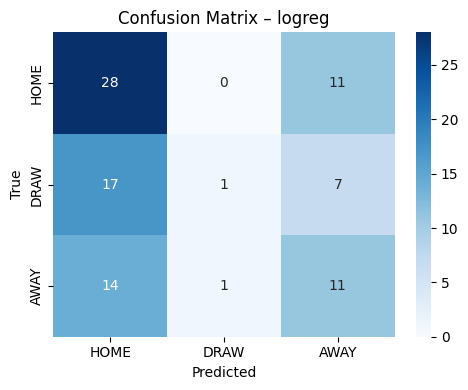

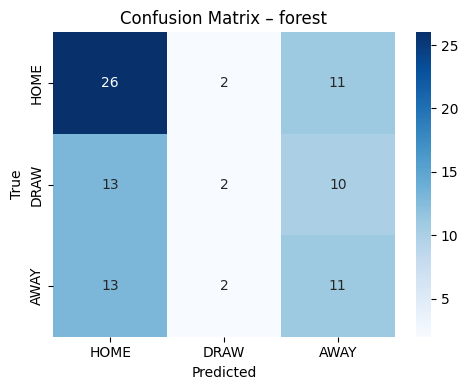

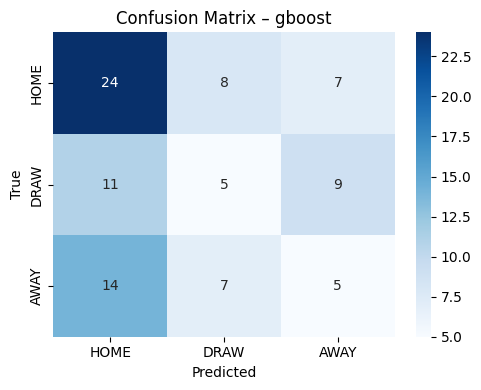

model  accuracy  log_loss  brier_score
1  forest  0.433333  1.064178     0.214696
0  logreg  0.444444  1.089913     0.218926
2  gboost  0.377778  1.188871     0.238725

In [34]:
results1=[]

for name, model in pipelines.items():
    
    # ---- Train ----
    model.fit(X_train, y_train)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results1.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(results1)
display(df_results.sort_values("log_loss"))

## Essai avec des pipelines calibrées

In [35]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_pipelines = {}
for name, pipe in pipelines.items():
    calibrated_pipelines[name] = CalibratedClassifierCV(pipe, cv=5, method='isotonic')

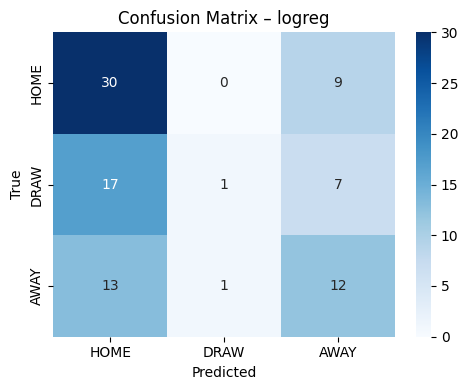

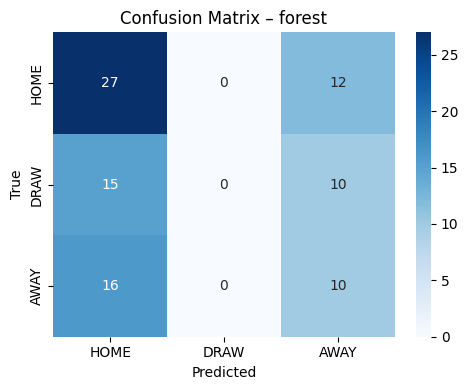

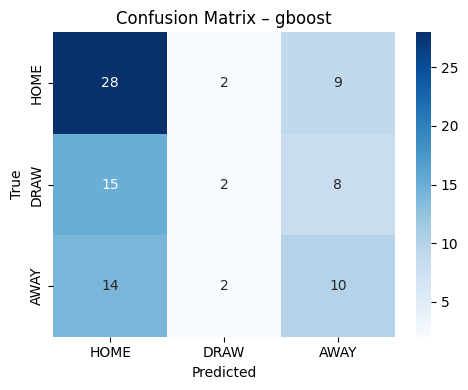

model  accuracy  log_loss  brier_score
1  forest  0.411111  1.062785     0.213121
0  logreg  0.477778  1.095489     0.219000
2  gboost  0.444444  1.098679     0.218944

In [36]:
results1_cal=[]

for name, model in calibrated_pipelines.items():
    
    # ---- Train ----
    model.fit(X_train, y_train)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results1_cal.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(results1_cal)
display(df_results.sort_values("log_loss"))

## Hyperparameter fine tuning

In [37]:
from sklearn.model_selection import GridSearchCV


In [38]:
lr_params={
    'logisticregression__C':[0.01,0.1,1,10],
    'logisticregression__penalty':['l2'],
    'logisticregression__solver':  ['lbfgs']
}

rf_params = {
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__max_depth': [None, 10],
    'randomforestclassifier__min_samples_leaf': [1, 4]
}

gb_params = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05,0.1],
    'gradientboostingclassifier__max_depth': [3, 5],
}

params={
    'logreg':lr_params,
    'forest':rf_params,
    'gboost':gb_params
}




In [39]:
fitted_models={}
for name, estimator in pipelines.items():
    print("fitting model:",name)
    model=GridSearchCV(estimator,
                       param_grid=params[name],
                       cv=3,scoring='neg_log_loss')
    model.fit(X_train,y_train)
    fitted_models[name]=model

fitting model: logreg
fitting model: forest
fitting model: gboost


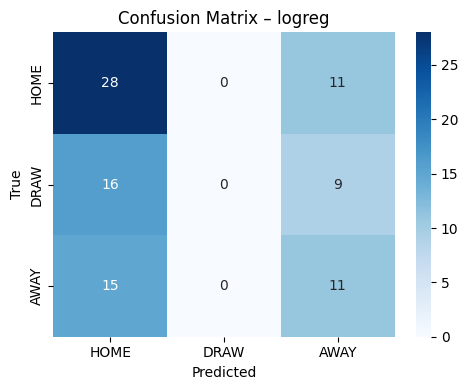

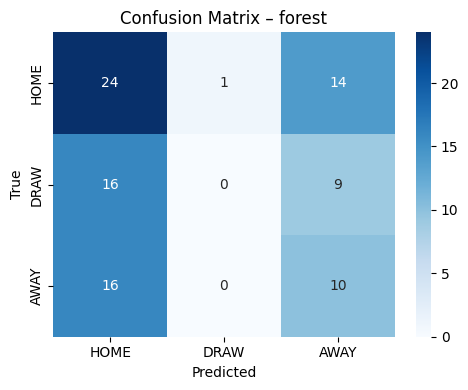

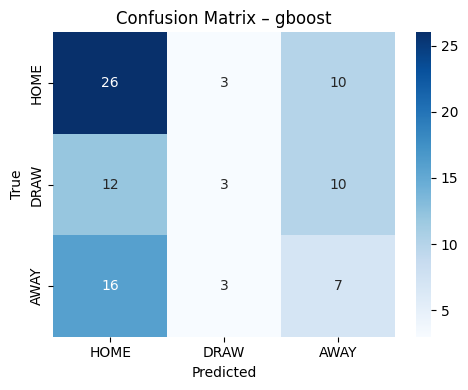

model  accuracy  log_loss  brier_score
1  forest  0.377778  1.060080     0.213426
0  logreg  0.433333  1.086808     0.219021
2  gboost  0.400000  1.097132     0.220894

In [40]:
results1_grid=[]
for name, model in fitted_models.items():
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results1_grid.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(results1_grid)
display(df_results.sort_values("log_loss"))

## Calibré et random searché

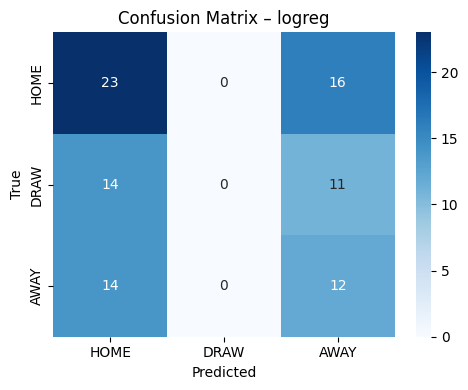

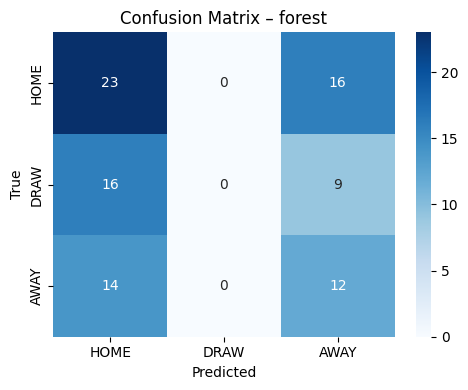

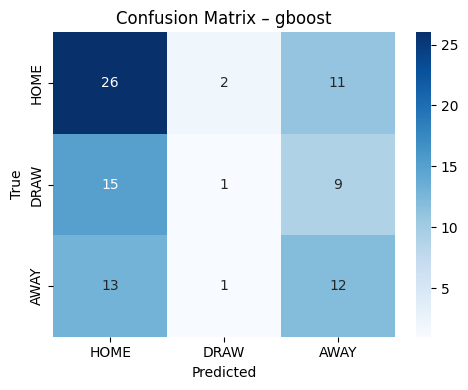

model  accuracy  log_loss  brier_score
1  forest  0.388889  1.067623     0.215246
2  gboost  0.433333  1.074879     0.214225
0  logreg  0.388889  1.494188     0.226192

In [41]:
results1_grid_cal=[]
for name, model in fitted_models.items():
    # ---- Predict ----
    calibrated = CalibratedClassifierCV(model.best_estimator_, cv=5, method='isotonic')
    calibrated.fit(X_train, y_train)

    y_pred = calibrated.predict(X_valid)
    y_proba = calibrated.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(calibrated.classes_)
    ])
    
    results1_grid_cal.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(results1_grid_cal)
display(df_results.sort_values("log_loss"))

## Résumé

In [43]:
display(pd.DataFrame(results1).sort_values("log_loss"))
display(pd.DataFrame(results1_cal).sort_values("log_loss"))
display(pd.DataFrame(results1_grid).sort_values("log_loss"))
display(pd.DataFrame(results1_grid_cal).sort_values("log_loss"))



model  accuracy  log_loss  brier_score
1  forest  0.433333  1.064178     0.214696
0  logreg  0.444444  1.089913     0.218926
2  gboost  0.377778  1.188871     0.238725

model  accuracy  log_loss  brier_score
1  forest  0.411111  1.062785     0.213121
0  logreg  0.477778  1.095489     0.219000
2  gboost  0.444444  1.098679     0.218944

model  accuracy  log_loss  brier_score
1  forest  0.377778  1.060080     0.213426
0  logreg  0.433333  1.086808     0.219021
2  gboost  0.400000  1.097132     0.220894

model  accuracy  log_loss  brier_score
1  forest  0.388889  1.067623     0.215246
2  gboost  0.433333  1.074879     0.214225
0  logreg  0.388889  1.494188     0.226192

We want our models to give accurate probabilities, so the metrcs we are most interested in are the log-loss and the brier-score. The log-loss of the naive model (based on the cross-enthropy calculated with probabilities in the training set and the validation set) is of around 1.09: forest is usually better, and for logreg and gboost it depends. But Though forest is better than the naive model, it is not yet very good.

*Why aren't the models good?*

The main issue is that all the variables we have included concern either the home team or the away team, and we need variables that *compare* the two teams.

# Adding variables of importance

In [50]:
df_training.columns

Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')

In [55]:
def adding_comparative_features(df):
    df2=df.copy()
    df2['dif_avg_points']=df['home_avg_points_before_match']-df['away_avg_points_before_match']
    df2['dif_avg_goal_for']=df['home_avg_goals_for']-df['away_avg_goals_for']
    df2['dif_avg_goal_against']=df['home_avg_goals_against']-df['away_avg_goals_against']
    df2['dif_win_rate']=df['home_home_win_rate']-df['away_away_win_rate']
    df2['dif_loss_rate']=df['home_home_loss_rate']-df['away_away_loss_rate']
    df2['dif_ranking']=df['home_ranking_before_match']-df['away_ranking_before_match']
    df2['dif_form_last5']=df['home_form_last5']-df['away_form_last5']
    return df2




In [ ]:
df_training2=adding_comparative_features(df_training)


In [ ]:
print(df_training2.columns)
print(df_training2.shape)


Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5', 'dif_avg_points',
       'dif_avg_goal_for', 'dif_avg_goal_against', 'dif_win_rate',
       'dif_loss_rate', 'dif_ranking', 'dif_form_last5'],
      dtype='object')
(522, 23)
Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_l

## Distribution des nouvelles variables

In [65]:
new_variable=['dif_avg_points',
       'dif_avg_goal_for', 'dif_avg_goal_against', 'dif_win_rate',
       'dif_loss_rate', 'dif_ranking', 'dif_form_last5']

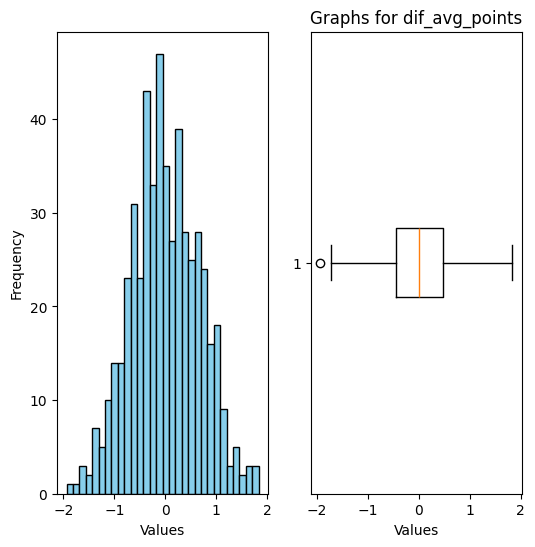

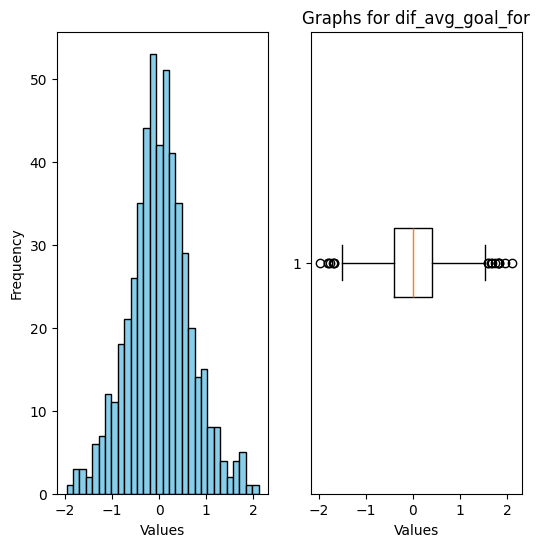

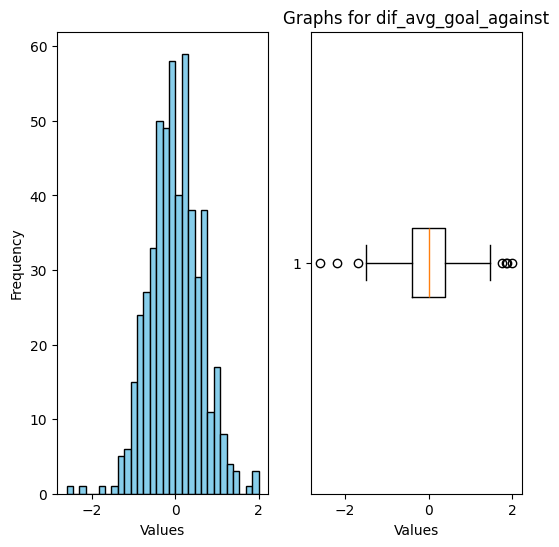

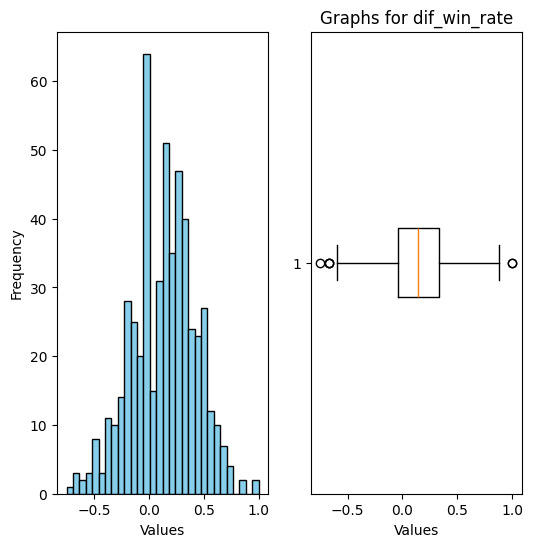

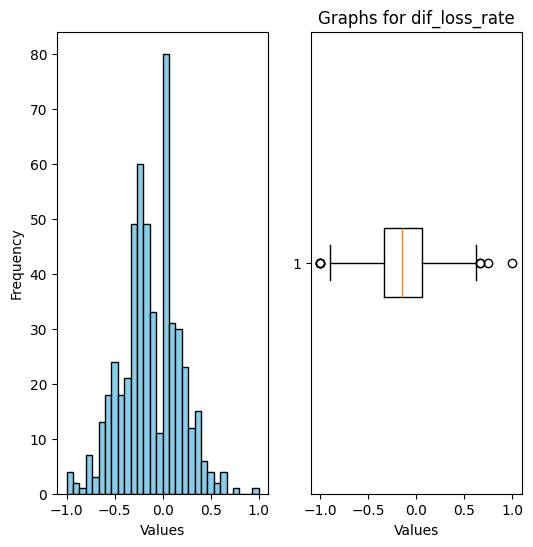

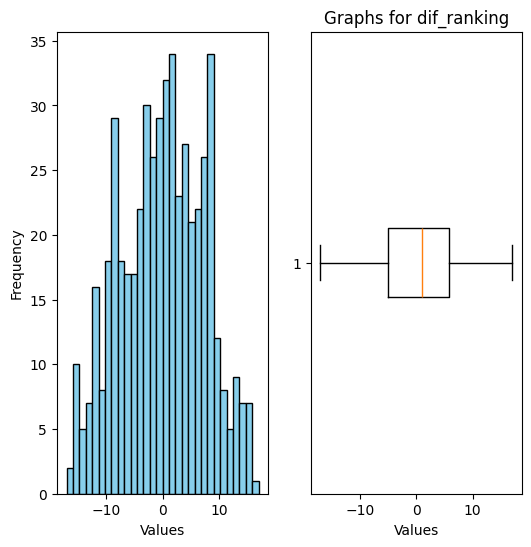

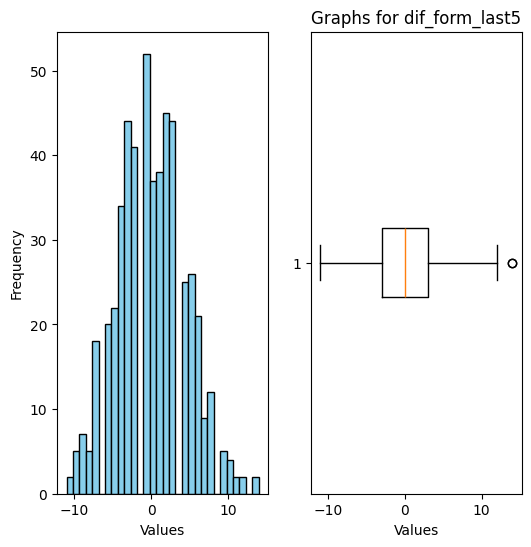

In [66]:
#variable=['home_avg_points_before_match', 'home_avg_goals_for']

for var in new_variable:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    axs[0].hist(df_training2[var],bins=30, color='skyblue', edgecolor='black')
    # Adding labels and title
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    #axs[0].set_title(f'Basic Histogram of {var}')


    axs[1].boxplot(df_training2[var],vert=False)
    axs[1].set_xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()


## Analyse des corrélations

In [64]:
corr2=df_training2.corr(numeric_only=True)

#plotting the heatmap for correlation


fig = plt.figure(figsize=(30,30), dpi = 480)
ax = sns.heatmap(corr2, annot=True, fmt = '.2f')


We find that the differences are related to both the 'home' and 'away' values. Additionally, the ranking and avg points are highly correlated, and once again we will disregard the ranking variables in the following due to this very high correlation

## Relation entre cible et nouvelles variables

In [67]:
new_variable=['dif_avg_points',
       'dif_avg_goal_for', 'dif_avg_goal_against', 'dif_win_rate',
       'dif_loss_rate', 'dif_ranking', 'dif_form_last5']


 Variable : dif_avg_points
    → F = 27.6571
    → p-value = 0.000000


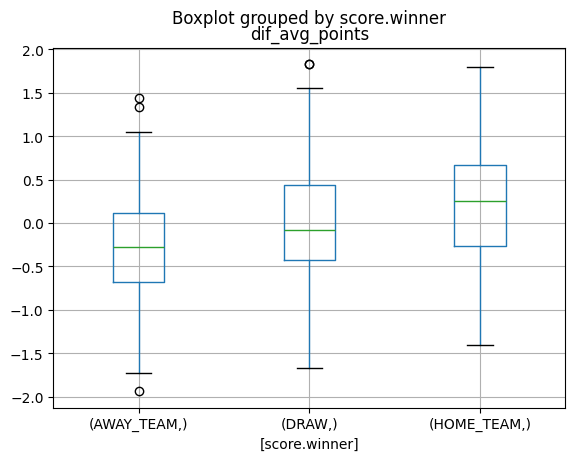


 Variable : dif_avg_goal_for
    → F = 32.4583
    → p-value = 0.000000


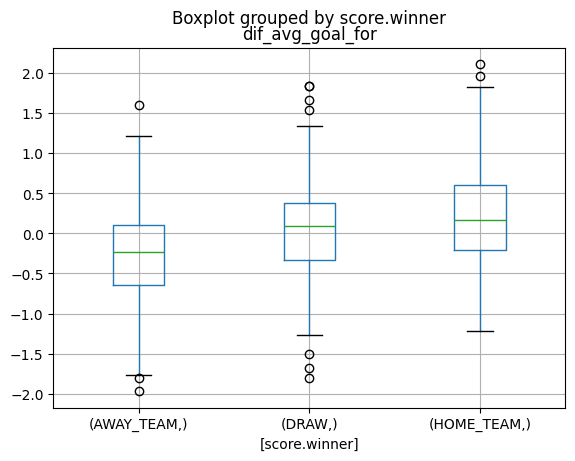


 Variable : dif_avg_goal_against
    → F = 16.5436
    → p-value = 0.000000


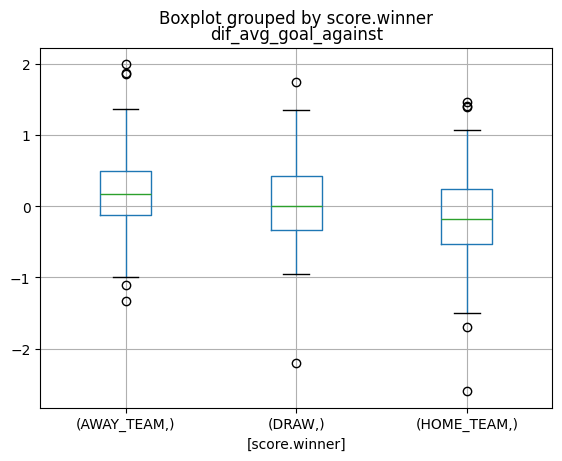


 Variable : dif_win_rate
    → F = 23.8617
    → p-value = 0.000000


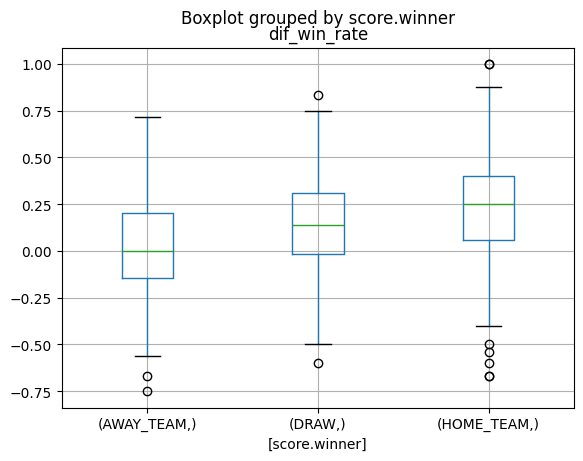


 Variable : dif_loss_rate
    → F = 19.4393
    → p-value = 0.000000


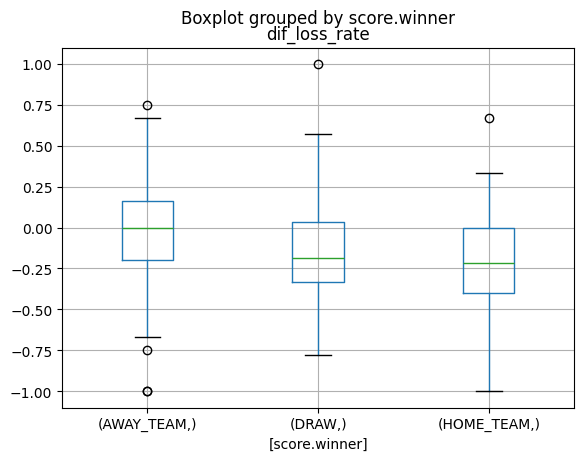


 Variable : dif_ranking
    → F = 28.3034
    → p-value = 0.000000


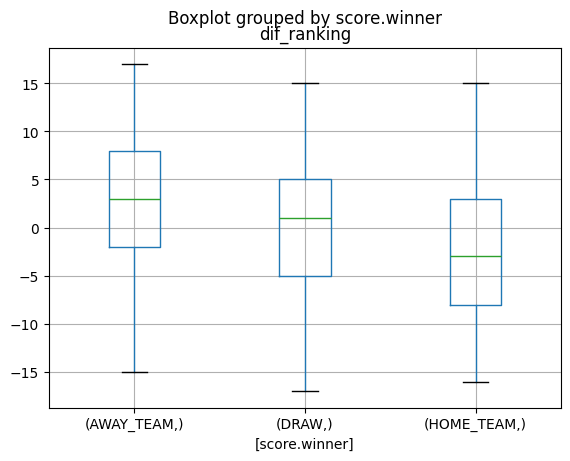


 Variable : dif_form_last5
    → F = 12.8958
    → p-value = 0.000003


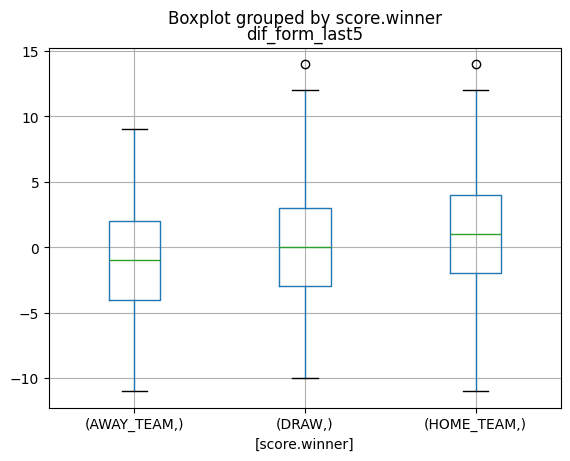

In [69]:
for var in new_variable:
    groups = [df_training2[df_training2["score.winner"] == c][var].dropna()
              for c in classes]

    f_stat, p_val = f_oneway(*groups)

    print(f"\n Variable : {var}")
    print(f"    → F = {f_stat:.4f}")
    print(f"    → p-value = {p_val:.6f}")
    df_training2.boxplot(column=[var],by=['score.winner'])
    #plt.xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    #plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()

## Analyse temporelle


 Variable : dif_avg_points
    → Correlation with mathchday = 0.0075


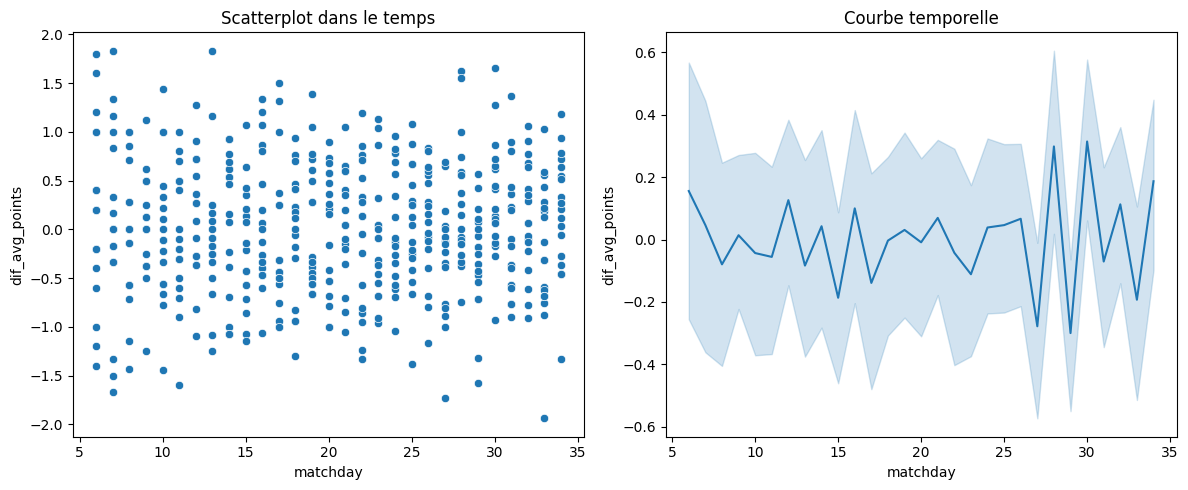


 Variable : dif_avg_goal_for
    → Correlation with mathchday = -0.0044


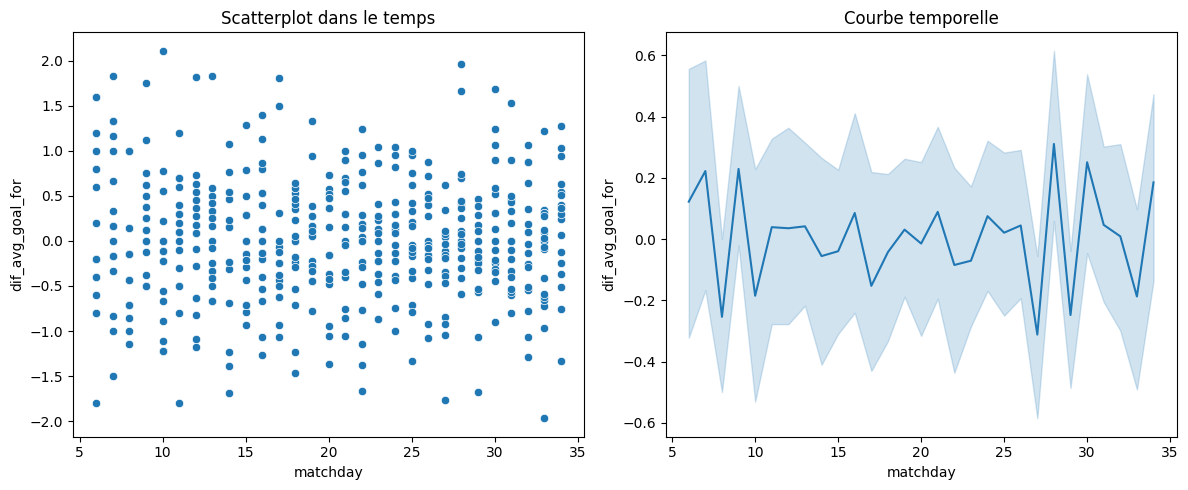


 Variable : dif_avg_goal_against
    → Correlation with mathchday = -0.0111


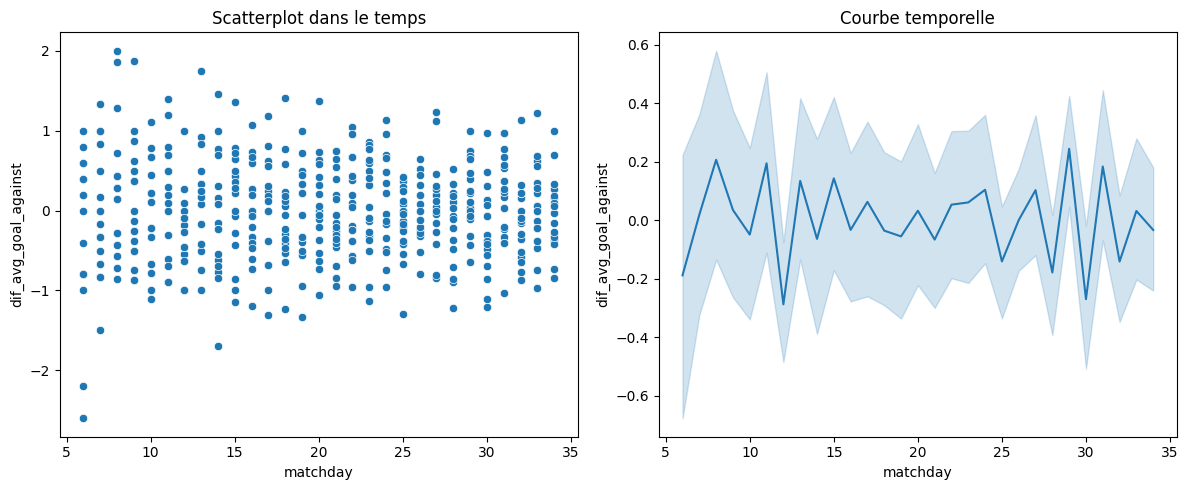


 Variable : dif_win_rate
    → Correlation with mathchday = -0.0811


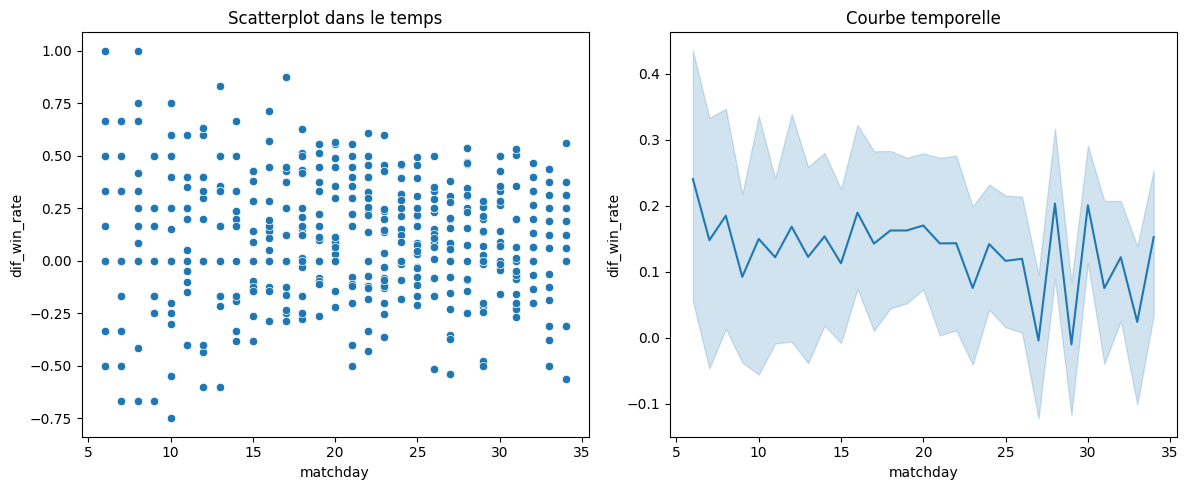


 Variable : dif_loss_rate
    → Correlation with mathchday = 0.0650


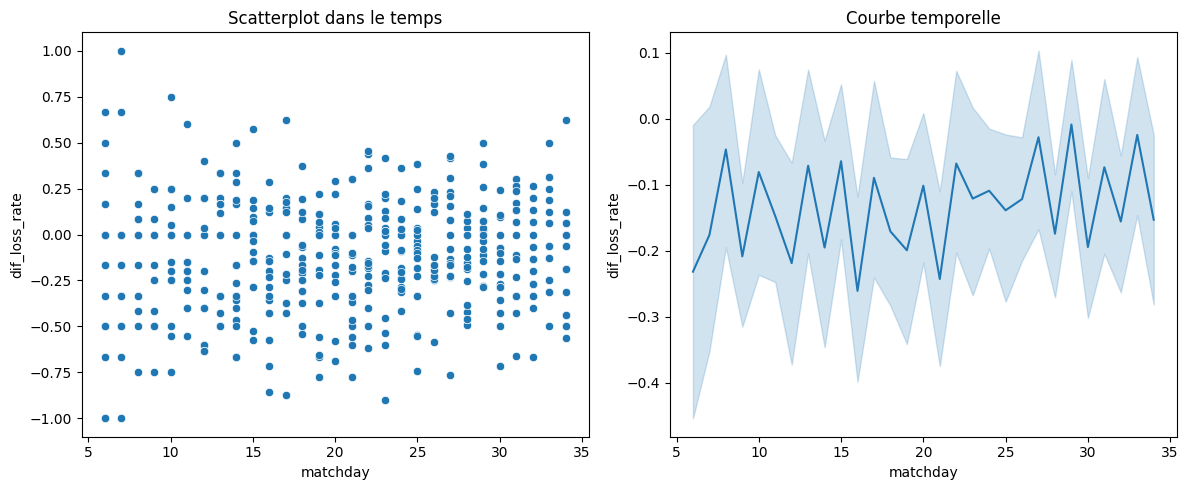


 Variable : dif_ranking
    → Correlation with mathchday = -0.0106


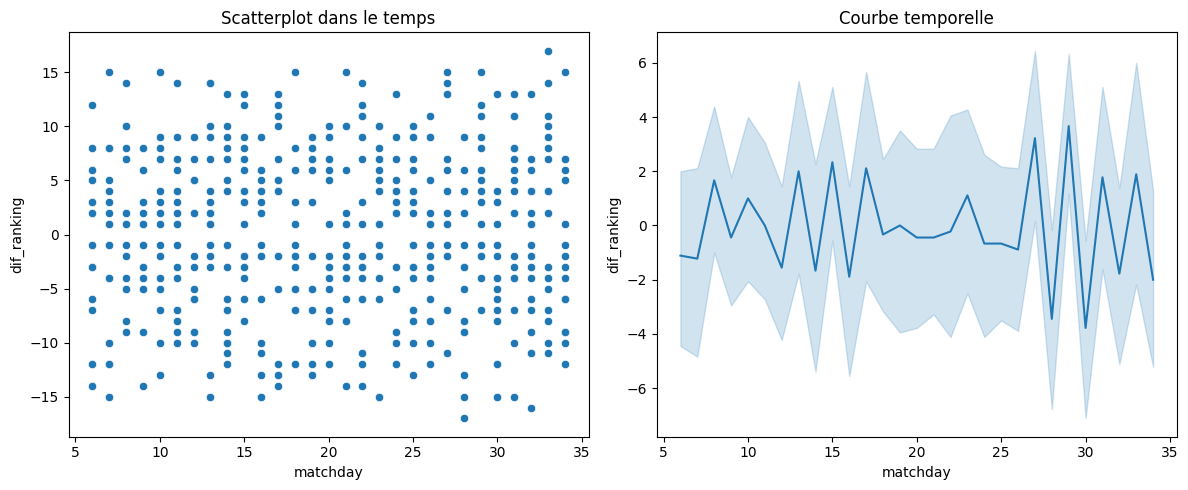


 Variable : dif_form_last5
    → Correlation with mathchday = 0.0064


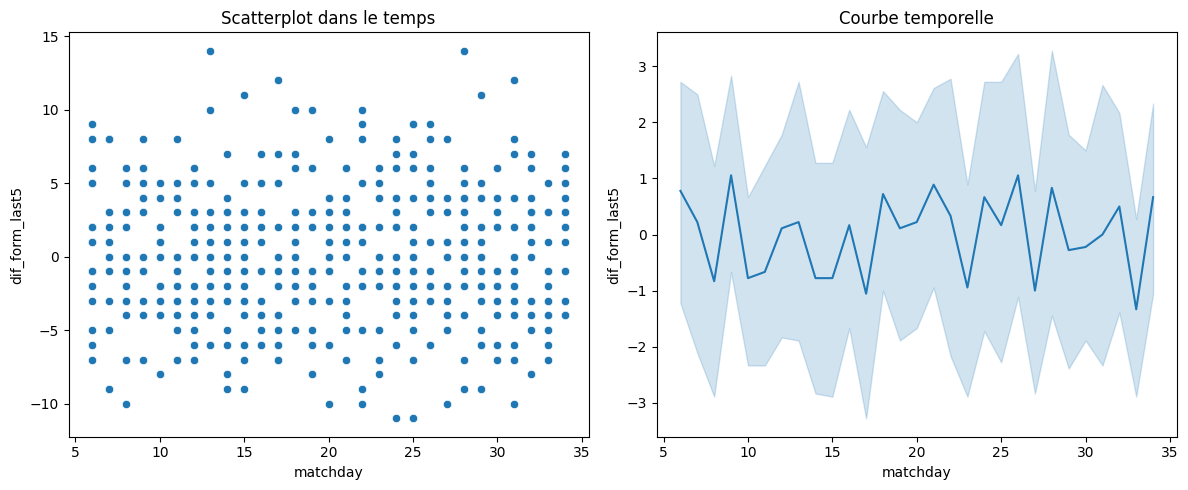

In [71]:
for var in new_variable:
    corr1=corr2.loc["matchday",var]
    print(f"\n Variable : {var}")
    print(f"    → Correlation with mathchday = {corr1:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graph 1
    sns.scatterplot(
        data=df_training2,
        x="matchday",
        y=var,
        ax=axs[0]
    )
    axs[0].set_title("Scatterplot dans le temps")

    # Graph 2
    sns.lineplot(
        data=df_training2,
        x="matchday",
        y=var,
        ax=axs[1]
    )
    axs[1].set_title("Courbe temporelle")

    plt.tight_layout()
    plt.show()



# Nouvelle modélisation

In [83]:
df_validation2=adding_comparative_features(df_for_validation)


In [84]:
X_train2=df_training2.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match","dif_ranking"])
y_train2=df_training2["score.winner"]

X_valid2=df_validation2.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match","dif_ranking"])
y_valid2=df_validation2["score.winner"]

## Pipelines

In [87]:
num_features2 = ['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_form_last5', 'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_form_last5','dif_avg_points', 'dif_avg_goal_for',
       'dif_avg_goal_against', 'dif_win_rate', 'dif_loss_rate',
       'dif_form_last5']

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features2)
    ]
)

In [88]:
pipelines2={
    'logreg': make_pipeline(preprocessor2,LogisticRegression(max_iter=1000,solver='lbfgs')),
    'forest':make_pipeline(preprocessor2,RandomForestClassifier()),
    'gboost':make_pipeline(preprocessor2,GradientBoostingClassifier())
}

## Modélisation basique

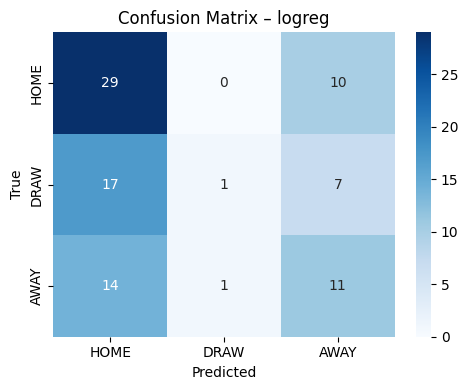

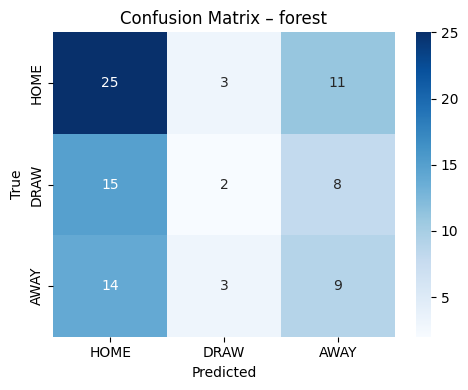

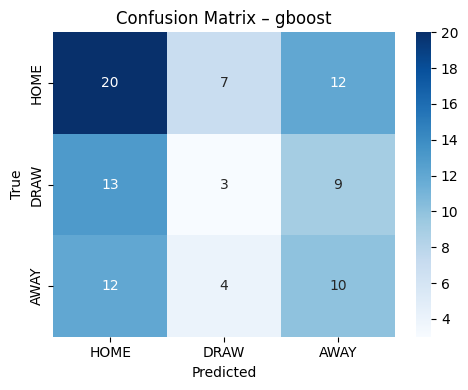

model  accuracy  log_loss  brier_score
1  forest  0.400000  1.078953     0.215331
0  logreg  0.455556  1.090891     0.219103
2  gboost  0.366667  1.244646     0.251619

In [89]:
results2=[]

for name, model in pipelines2.items():
    
    # ---- Train ----
    model.fit(X_train2, y_train2)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid2)
    y_proba = model.predict_proba(X_valid2)

    # ---- Metrics ----
    acc = accuracy_score(y_valid2, y_pred)
    ll  = log_loss(y_valid2, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid2 == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results2.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid2, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(results2)
display(df_results.sort_values("log_loss"))

In [90]:
display(pd.DataFrame(results1).sort_values("log_loss"))

model  accuracy  log_loss  brier_score
1  forest  0.433333  1.064178     0.214696
0  logreg  0.444444  1.089913     0.218926
2  gboost  0.377778  1.188871     0.238725

On ne voit pour le moment pas d'amélioration flagrante voir même plutôt moins bien que les modèles sans indicateurs de tension. Essayons de calibrer

## Calibration

In [92]:
calibrated_pipelines2 = {}
for name, pipe in pipelines2.items():
    calibrated_pipelines2[name] = CalibratedClassifierCV(pipe, cv=5, method='isotonic')

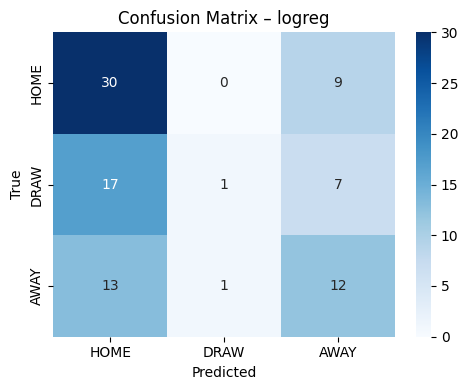

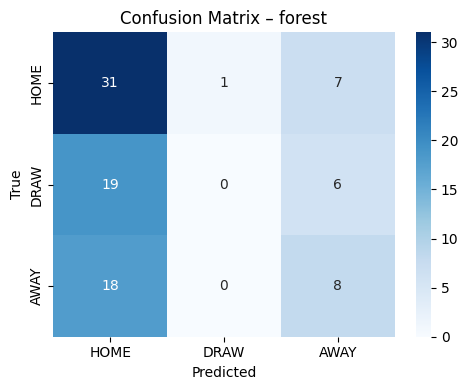

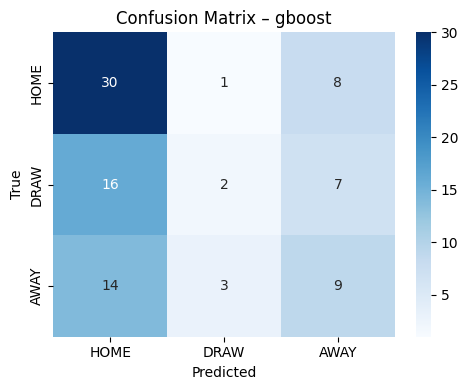

model  accuracy  log_loss  brier_score
2  gboost  0.455556  1.070710     0.214785
1  forest  0.433333  1.080317     0.216294
0  logreg  0.477778  1.096247     0.219312

In [93]:
results2_cal=[]

for name, model in calibrated_pipelines2.items():
    
    # ---- Train ----
    model.fit(X_train2, y_train2)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid2)
    y_proba = model.predict_proba(X_valid2)

    # ---- Metrics ----
    acc = accuracy_score(y_valid2, y_pred)
    ll  = log_loss(y_valid2, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid2 == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results2_cal.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid2, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(results2_cal)
display(df_results.sort_values("log_loss"))

In [94]:
display(pd.DataFrame(results1_cal).sort_values("log_loss"))

model  accuracy  log_loss  brier_score
1  forest  0.411111  1.062785     0.213121
0  logreg  0.477778  1.095489     0.219000
2  gboost  0.444444  1.098679     0.218944

On commence à voir les effets une fois calibré! Le modèle de gboost notamment est grandement amélioré, le modèle logreg plutôt inchangé, et le modèle forest moins bien en terme de log loss mais amélioré en accuracy. On va essayer hyper parameter fine tuning

## Fine tuning

In [96]:
fitted_models2={}
for name, estimator in pipelines2.items():
    print("fitting model:",name)
    model=GridSearchCV(estimator,
                       param_grid=params[name],
                       cv=3,scoring='neg_log_loss')
    model.fit(X_train2,y_train2)
    fitted_models2[name]=model

fitting model: logreg
fitting model: forest
fitting model: gboost


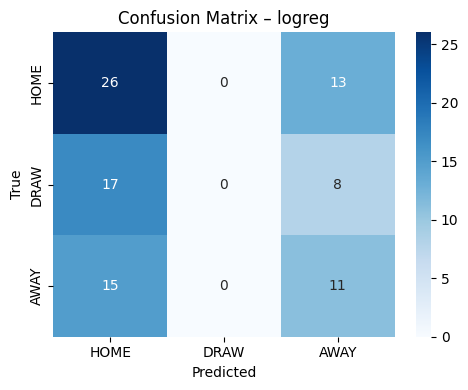

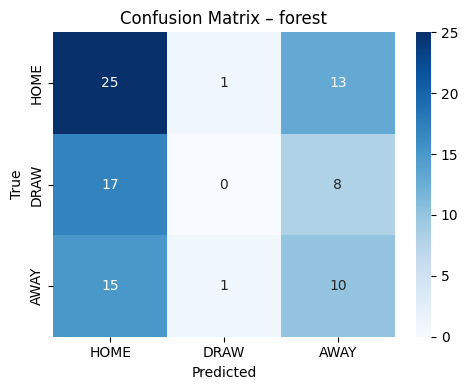

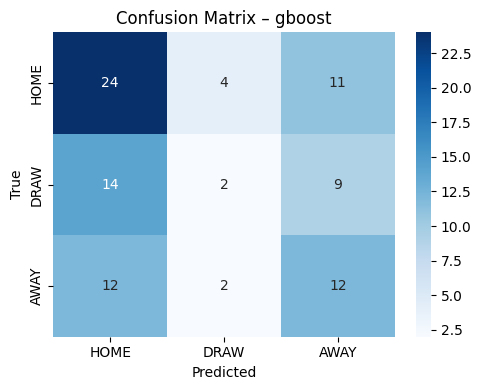

model  accuracy  log_loss  brier_score
1  forest  0.388889  1.074067     0.216518
0  logreg  0.411111  1.087688     0.219277
2  gboost  0.422222  1.118520     0.226627

In [97]:
results2_grid=[]
for name, model in fitted_models2.items():
    # ---- Predict ----
    y_pred = model.predict(X_valid2)
    y_proba = model.predict_proba(X_valid2)

    # ---- Metrics ----
    acc = accuracy_score(y_valid2, y_pred)
    ll  = log_loss(y_valid2, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid2 == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results2_grid.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid2, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(results2_grid)
display(df_results.sort_values("log_loss"))

In [ ]:
display(pd.DataFrame(results1_grid).sort_values("log_loss"))

model  accuracy  log_loss  brier_score
1  forest  0.377778  1.060080     0.213426
0  logreg  0.433333  1.086808     0.219021
2  gboost  0.400000  1.097132     0.220894

Performances are not that much better, maybe even slighlty worse, but we will see once calibration is done

## Calibration after fine tuning

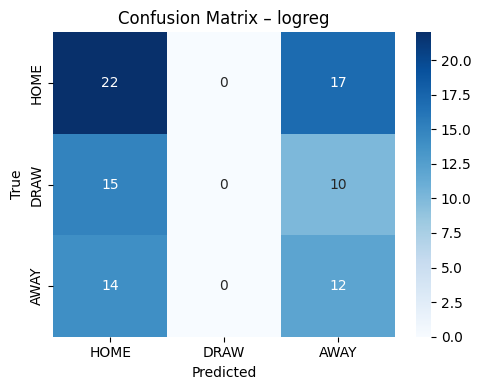

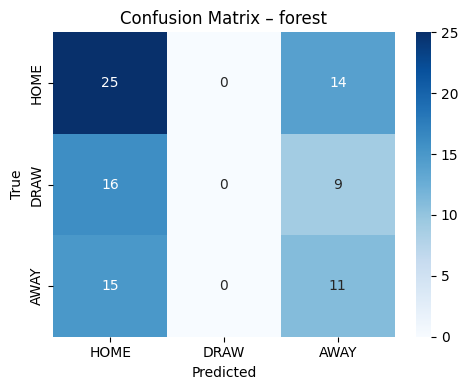

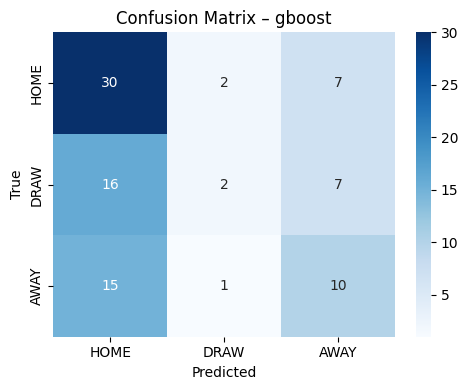

model  accuracy  log_loss  brier_score
2  gboost  0.466667  1.060625     0.212487
1  forest  0.400000  1.073864     0.215779
0  logreg  0.377778  1.484608     0.224214

In [99]:
results2_grid_cal=[]
for name, model in fitted_models2.items():
    # ---- Predict ----
    calibrated = CalibratedClassifierCV(model.best_estimator_, cv=5, method='isotonic')
    calibrated.fit(X_train2, y_train2)

    y_pred = calibrated.predict(X_valid2)
    y_proba = calibrated.predict_proba(X_valid2)

    # ---- Metrics ----
    acc = accuracy_score(y_valid2, y_pred)
    ll  = log_loss(y_valid2, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid2 == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(calibrated.classes_)
    ])
    
    results2_grid_cal.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid2, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(results2_grid_cal)
display(df_results.sort_values("log_loss"))

In [100]:
display(pd.DataFrame(results1_grid_cal).sort_values("log_loss"))

model  accuracy  log_loss  brier_score
1  forest  0.388889  1.067623     0.215246
2  gboost  0.433333  1.074879     0.214225
0  logreg  0.388889  1.494188     0.226192